## 1. Setup and Imports

In [1]:
# Fix OpenMP conflict
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# Add parent directory to path
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# v0.2.1 imports
import gimbal
from gimbal import (
    DEMO_V0_1_SKELETON,
    SyntheticDataConfig,
    generate_demo_sequence,
    # v0.2.1 new functions
    triangulate_multi_view,
    CleaningConfig,
    clean_keypoints_2d,
    clean_keypoints_3d,
    compute_direction_statistics,
    build_priors_from_statistics,
    # Model building
    build_camera_observation_model,
    add_directional_hmm_prior,
)
from gimbal.fit_params import initialize_from_groundtruth

print("✓ Imports successful!")
print(f"PyMC version: {pm.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Imports successful!
PyMC version: 5.26.1
NumPy version: 2.3.5


## 2. Generate Synthetic Data

We'll generate a longer sequence (100 frames) to have enough data for computing reliable statistics.

In [4]:
# Configuration for demo
config = SyntheticDataConfig(
    T=100,              # More frames for better statistics
    C=3,                # 3 cameras
    S=3,                # 3 hidden states
    kappa=10.0,         # Lower directional noise (was 5.0)
    obs_noise_std=0.5,  # Much lower 2D noise (was 3.0)
    occlusion_rate=0.02,# Much lower occlusion rate (was 0.1)
    random_seed=42,
)

print("Generating synthetic motion data...")
data = generate_demo_sequence(DEMO_V0_1_SKELETON, config)

print("\n✓ Data generation complete!")
print(f"  Skeleton: {len(DEMO_V0_1_SKELETON.joint_names)} joints")
print(f"  Joint names: {DEMO_V0_1_SKELETON.joint_names}")
print(f"  Timesteps: {data.config.T}")
print(f"  Cameras: {data.config.C}")
print(f"  True states: {np.bincount(data.true_states)}")

# Store observed 2D keypoints for pipeline
y_observed_2d = data.y_observed  # (C, T, K, 2)
camera_proj = data.camera_proj   # (C, 3, 4)

print(f"\n  2D observations shape: {y_observed_2d.shape}")
print(f"  Occlusions: {np.sum(np.isnan(y_observed_2d))} pixels")

Generating synthetic motion data...

✓ Data generation complete!
  Skeleton: 6 joints
  Joint names: ['root', 'joint1', 'joint2', 'joint3', 'joint4', 'joint5']
  Timesteps: 100
  Cameras: 3
  True states: [57 23 20]

  2D observations shape: (3, 100, 6, 2)
  Occlusions: 72 pixels


### Visualize Ground Truth 3D Skeleton

Let's look at the true 3D skeleton motion before adding noise.

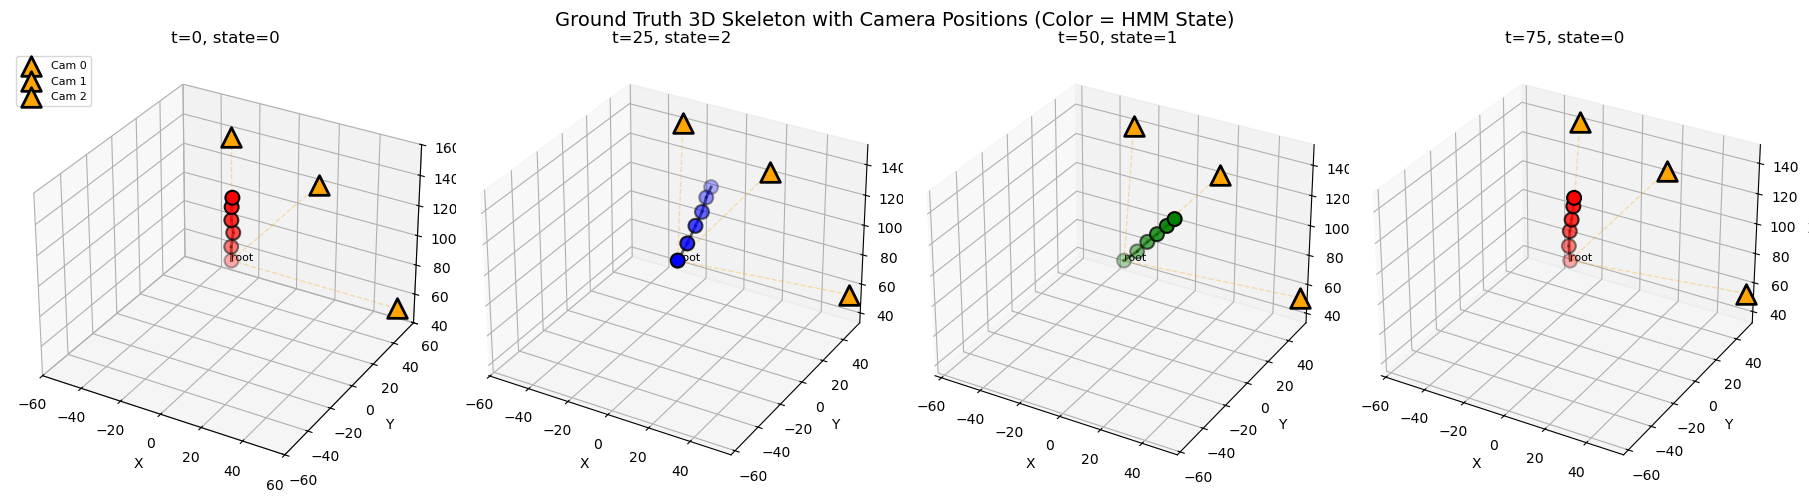

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from gimbal.camera_utils import camera_center_from_proj

# Plot ground truth 3D skeleton at multiple timesteps
fig = plt.figure(figsize=(18, 5))

timesteps_to_plot = [0, 25, 50, 75]
colors_by_state = ['red', 'green', 'blue']

for idx, t in enumerate(timesteps_to_plot, 1):
    ax = fig.add_subplot(1, 4, idx, projection='3d')
    
    # Get positions at timestep t
    x_t = data.x_true[t]  # (K, 3)
    state_t = data.true_states[t]
    
    # Plot skeleton bones
    for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
        if parent_idx >= 0:
            # Draw bone from parent to child
            parent_pos = x_t[parent_idx]
            child_pos = x_t[k]
            ax.plot([parent_pos[0], child_pos[0]], 
                   [parent_pos[1], child_pos[1]], 
                   [parent_pos[2], child_pos[2]], 
                   'k-', linewidth=2, alpha=0.6)
    
    # Plot joints
    ax.scatter(x_t[:, 0], x_t[:, 1], x_t[:, 2], 
              c=colors_by_state[state_t], s=100, 
              edgecolors='black', linewidth=1.5, zorder=10)
    
    # Label root joint
    ax.text(x_t[0, 0], x_t[0, 1], x_t[0, 2], 'root', fontsize=8)
    
    # Add camera positions using new camera utilities
    for c in range(data.config.C):
        P = camera_proj[c]  # (3, 4)
        cam_pos = camera_center_from_proj(P)
        
        # Plot camera as a pyramid
        ax.scatter([cam_pos[0]], [cam_pos[1]], [cam_pos[2]], 
                  c='orange', s=200, marker='^', edgecolors='black', 
                  linewidth=2, label=f'Cam {c}' if idx == 1 else '', zorder=20)
        
        # Draw line from camera to skeleton center
        ax.plot([cam_pos[0], x_t[0, 0]], 
               [cam_pos[1], x_t[0, 1]], 
               [cam_pos[2], x_t[0, 2]], 
               'orange', linewidth=1, alpha=0.3, linestyle='--')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f't={t}, state={state_t}')
    
    if idx == 1:
        ax.legend(loc='upper left', fontsize=8)
    
    # Set equal aspect ratio
    max_range = 60  # Increased to show cameras at new positions
    ax.set_xlim([x_t[0, 0] - max_range, x_t[0, 0] + max_range])
    ax.set_ylim([x_t[0, 1] - max_range, x_t[0, 1] + max_range])
    ax.set_zlim([x_t[0, 2] - max_range, x_t[0, 2] + max_range])

plt.suptitle('Ground Truth 3D Skeleton with Camera Positions (Color = HMM State)', fontsize=14)
plt.tight_layout()
plt.show()

### Visualize 2D Projections: Ground Truth (No Noise)

First, let's see what the clean projections look like without any noise or occlusions.

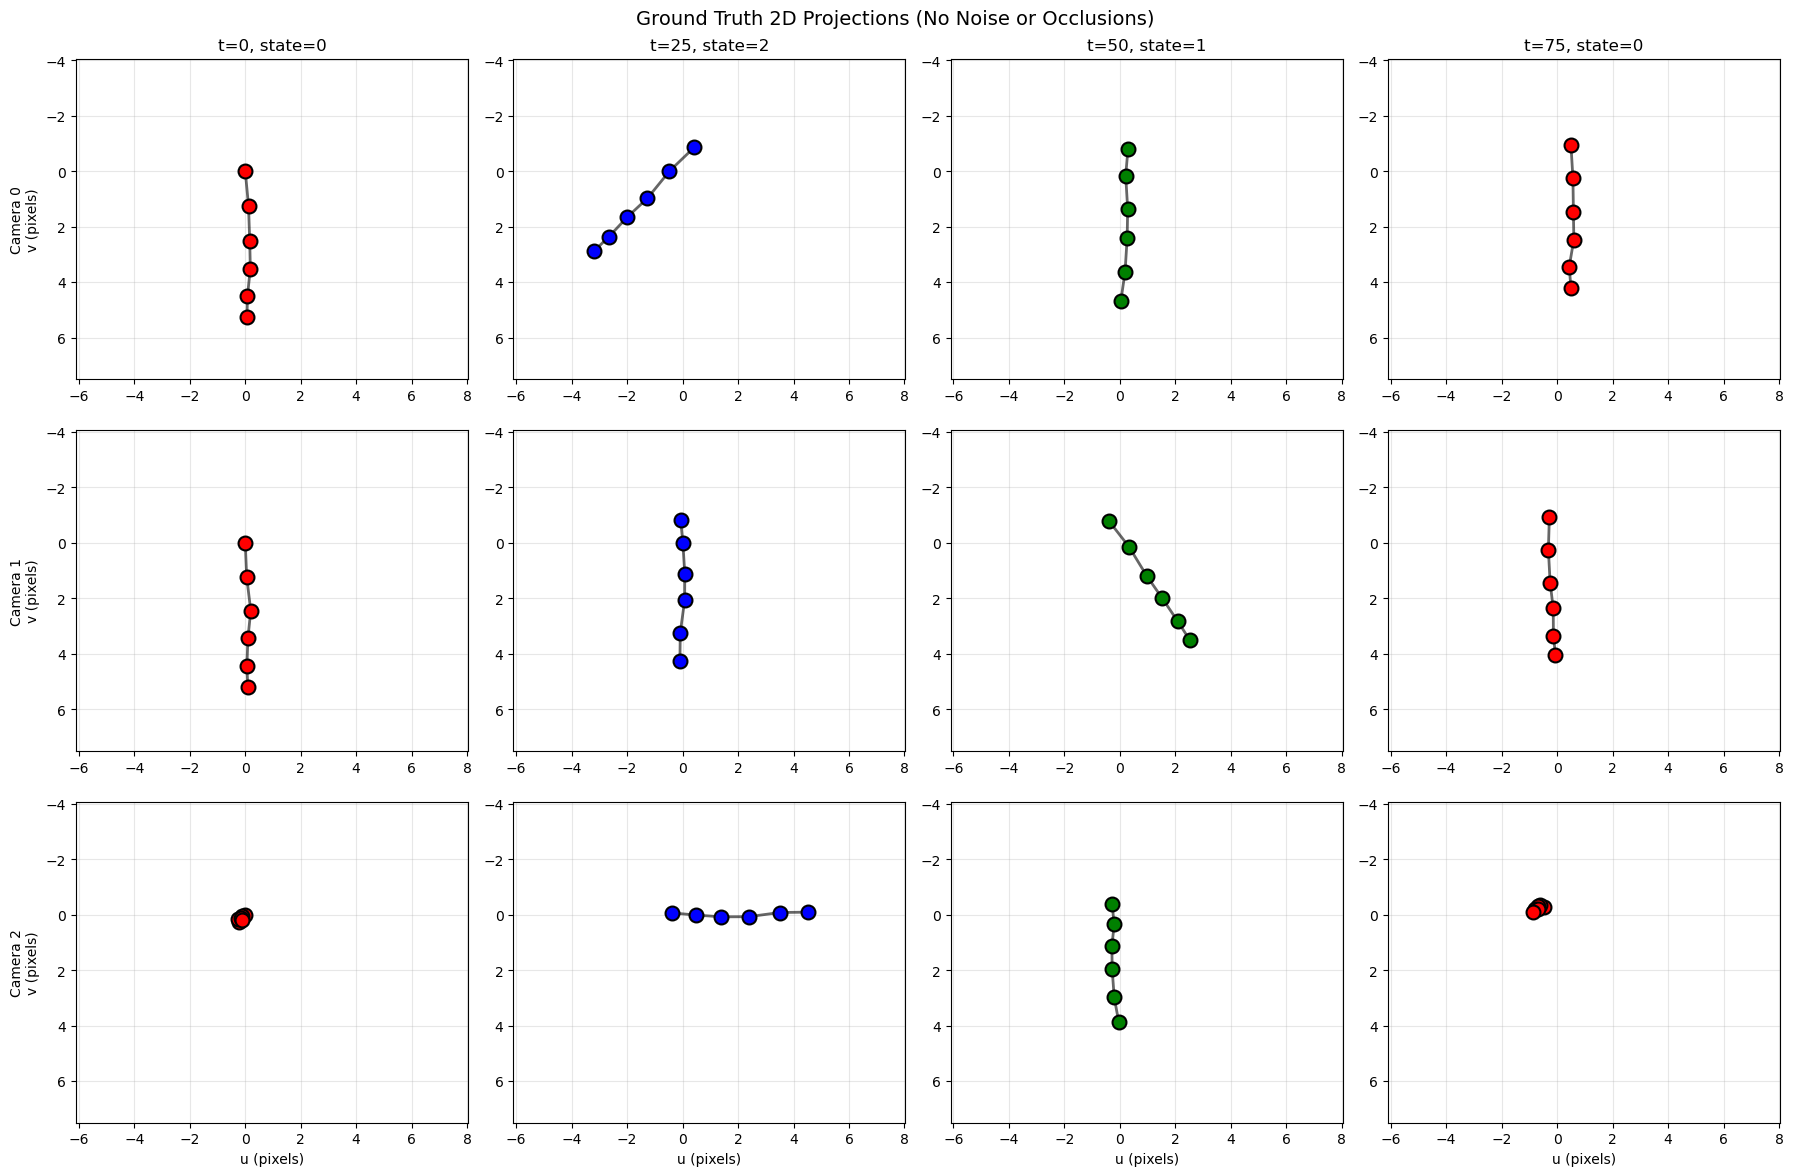

In [6]:
# Plot ground truth 2D projections (no noise, no occlusions)
# We'll project the true 3D positions directly using the camera matrices

timesteps_to_plot = [0, 25, 50, 75]
fig, axes = plt.subplots(data.config.C, len(timesteps_to_plot), figsize=(18, 12))

# Compute ground truth projections
def project_3d_to_2d(x_3d, P):
    """Project 3D points to 2D using camera matrix P."""
    # x_3d: (K, 3), P: (3, 4)
    # Convert to homogeneous coordinates
    x_homo = np.concatenate([x_3d, np.ones((x_3d.shape[0], 1))], axis=1)  # (K, 4)
    # Project
    y_homo = (P @ x_homo.T).T  # (K, 3)
    # Normalize
    y_2d = y_homo[:, :2] / y_homo[:, 2:3]  # (K, 2)
    return y_2d

# Determine consistent axis limits
u_min, u_max = np.nanmin(y_observed_2d[:, :, :, 0]), np.nanmax(y_observed_2d[:, :, :, 0])
v_min, v_max = np.nanmin(y_observed_2d[:, :, :, 1]), np.nanmax(y_observed_2d[:, :, :, 1])
u_range = u_max - u_min
v_range = v_max - v_min
padding = 0.2
u_lim = [u_min - padding * u_range, u_max + padding * u_range]
v_lim = [v_min - padding * v_range, v_max + padding * v_range]

for c in range(data.config.C):
    for t_idx, t in enumerate(timesteps_to_plot):
        ax = axes[c, t_idx]
        
        # Get ground truth 3D positions and project them
        x_true_t = data.x_true[t]  # (K, 3)
        y_gt = project_3d_to_2d(x_true_t, camera_proj[c])  # (K, 2)
        
        # Plot skeleton bones in 2D
        for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
            if parent_idx >= 0:
                parent_2d = y_gt[parent_idx]
                child_2d = y_gt[k]
                ax.plot([parent_2d[0], child_2d[0]], 
                       [parent_2d[1], child_2d[1]], 
                       'k-', linewidth=2, alpha=0.6)
        
        # Plot joints
        ax.scatter(y_gt[:, 0], y_gt[:, 1], 
                  c=colors_by_state[data.true_states[t]], 
                  s=100, edgecolors='black', linewidth=1.5, zorder=10)
        
        # Set consistent axis limits
        ax.set_xlim(u_lim)
        ax.set_ylim(v_lim)
        
        # Labels and styling
        if c == data.config.C - 1:
            ax.set_xlabel('u (pixels)')
        if t_idx == 0:
            ax.set_ylabel(f'Camera {c}\nv (pixels)')
        if c == 0:
            ax.set_title(f't={t}, state={data.true_states[t]}')
        
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')

plt.suptitle('Ground Truth 2D Projections (No Noise or Occlusions)', fontsize=14)
plt.tight_layout()
plt.show()

### Visualize 2D Projections: Observed Data (With Noise & Occlusions)

Now let's see the same frames with measurement noise and occlusions applied.

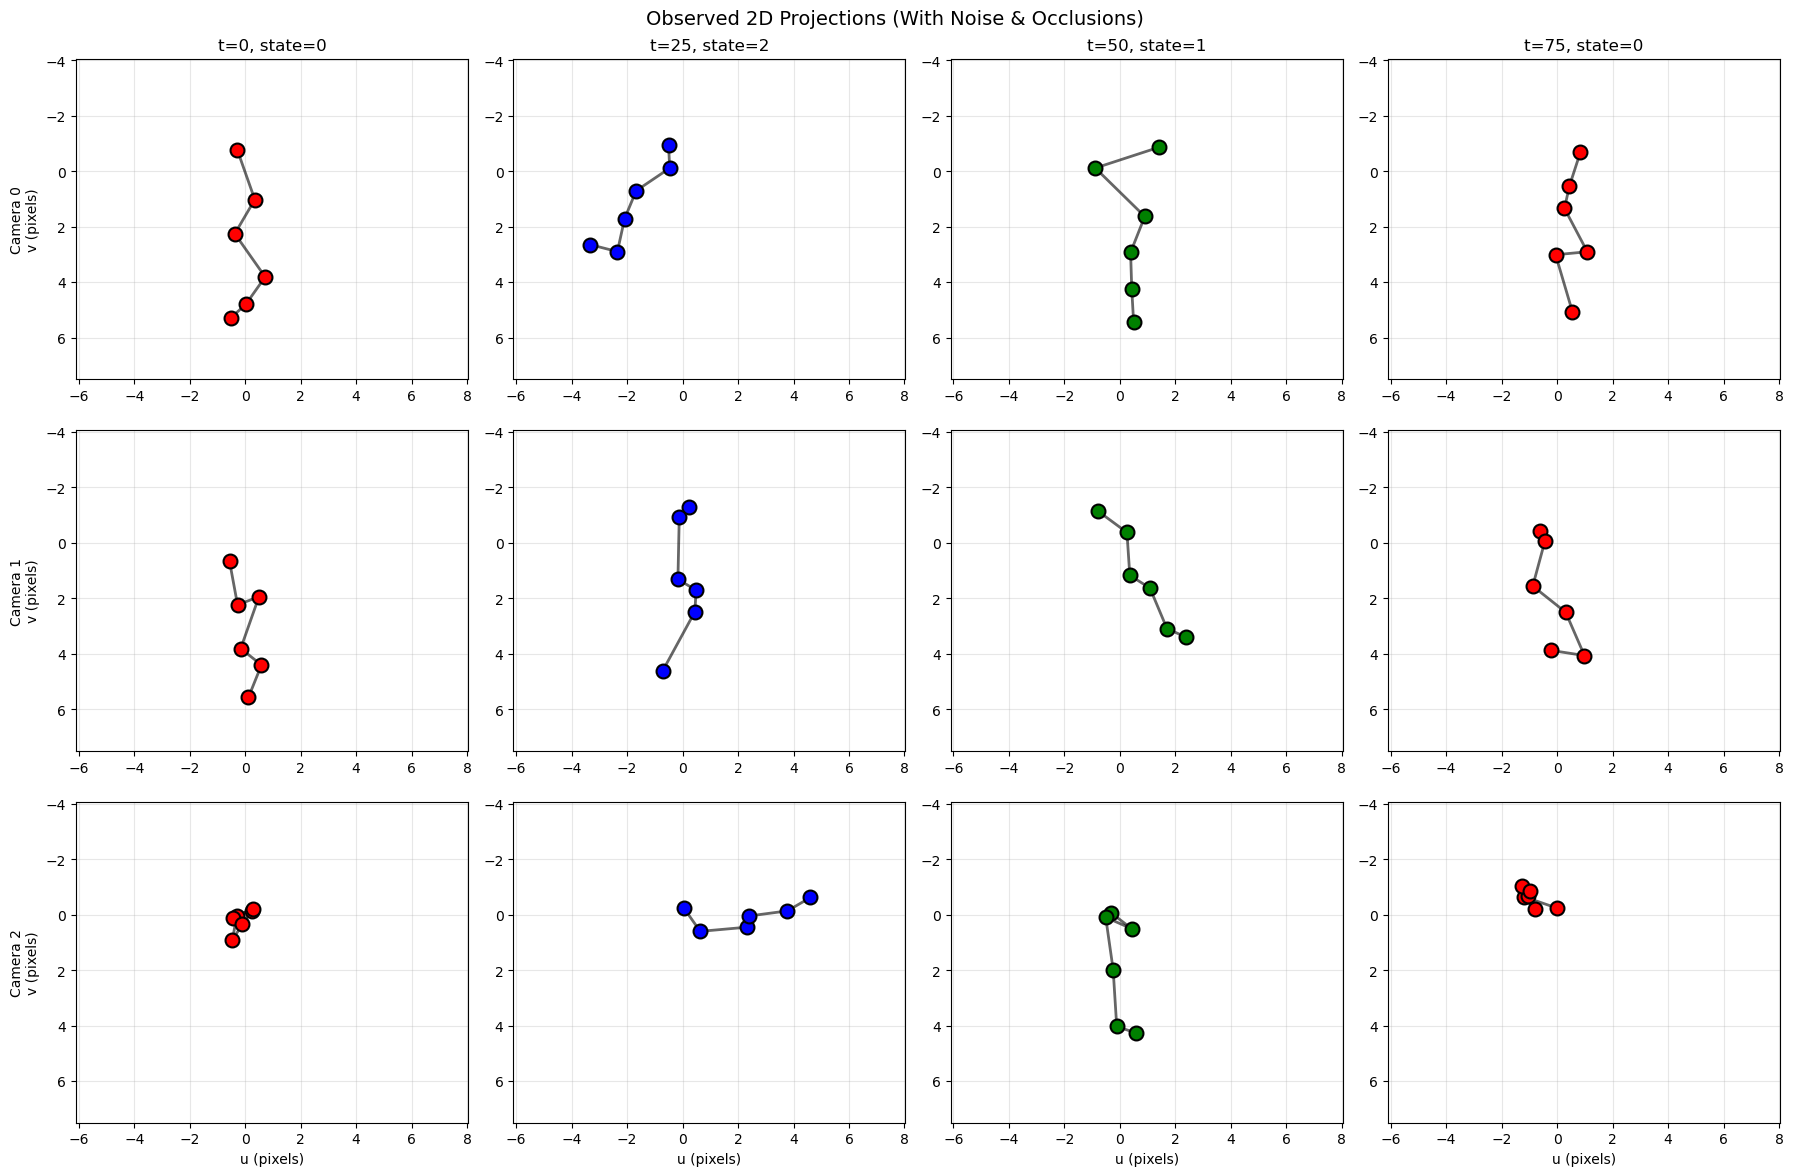

In [7]:
# Plot observed 2D projections with noise and occlusions
timesteps_to_plot = [0, 25, 50, 75]
fig, axes = plt.subplots(data.config.C, len(timesteps_to_plot), figsize=(18, 12))

# Use same axis limits as ground truth for comparison
for c in range(data.config.C):
    for t_idx, t in enumerate(timesteps_to_plot):
        ax = axes[c, t_idx]
        
        # Get observed 2D keypoints (with noise + occlusions)
        y_cam = y_observed_2d[c, t]  # (K, 2)
        
        # Plot skeleton bones in 2D
        for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
            if parent_idx >= 0:
                parent_2d = y_cam[parent_idx]
                child_2d = y_cam[k]
                
                # Only plot if both points are visible (not occluded)
                if not np.any(np.isnan(parent_2d)) and not np.any(np.isnan(child_2d)):
                    ax.plot([parent_2d[0], child_2d[0]], 
                           [parent_2d[1], child_2d[1]], 
                           'k-', linewidth=2, alpha=0.6)
        
        # Plot joints
        occluded_shown = False
        for k in range(len(DEMO_V0_1_SKELETON.joint_names)):
            if not np.any(np.isnan(y_cam[k])):
                ax.scatter(y_cam[k, 0], y_cam[k, 1], 
                          c=colors_by_state[data.true_states[t]], 
                          s=100, edgecolors='black', linewidth=1.5, zorder=10)
            else:
                # Mark occluded joints with X
                if not occluded_shown:
                    ax.scatter([], [], c='gray', s=100, marker='x', 
                              label='Occluded')
                    occluded_shown = True
        
        # Set consistent axis limits
        ax.set_xlim(u_lim)
        ax.set_ylim(v_lim)
        
        # Labels and styling
        if c == data.config.C - 1:
            ax.set_xlabel('u (pixels)')
        if t_idx == 0:
            ax.set_ylabel(f'Camera {c}\nv (pixels)')
        if c == 0:
            ax.set_title(f't={t}, state={data.true_states[t]}')
        
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
        
        if c == 0 and t_idx == 0 and occluded_shown:
            ax.legend(fontsize=8)

plt.suptitle('Observed 2D Projections (With Noise & Occlusions)', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Step 1: Clean 2D Keypoints

Detect and remove outliers using:
- **Jump detection**: Frame-to-frame position changes > z-score threshold
- **Bone length outliers**: Violations of expected bone lengths
- **Interpolation**: Fill gaps with linear interpolation

In [8]:
# Configure cleaning parameters
cleaning_config = CleaningConfig(
    jump_z_thresh=3.0,
    bone_z_thresh=3.0,
    max_gap=5,
    max_bad_joint_fraction=0.5,
)

print("Cleaning 2D keypoints...")
y_cleaned_2d, valid_frame_mask_2d, stats_2d = clean_keypoints_2d(
    y_observed_2d,
    DEMO_V0_1_SKELETON.parents,
    cleaning_config,
)

print(f"\n✓ 2D cleaning complete:")
print(f"  Jump outliers detected: {stats_2d['n_jump_outliers']}")
print(f"  Bone length outliers detected: {stats_2d['n_bone_outliers']}")
print(f"  Interpolated points: {stats_2d['n_interpolated']}")
print(f"  Invalid frames: {stats_2d['n_invalid_frames']}")

Cleaning 2D keypoints...

✓ 2D cleaning complete:
  Jump outliers detected: 257
  Bone length outliers detected: 10
  Interpolated points: 329
  Invalid frames: 3


### Visualize 2D Cleaning Results

Compare raw observations vs cleaned keypoints for one camera.

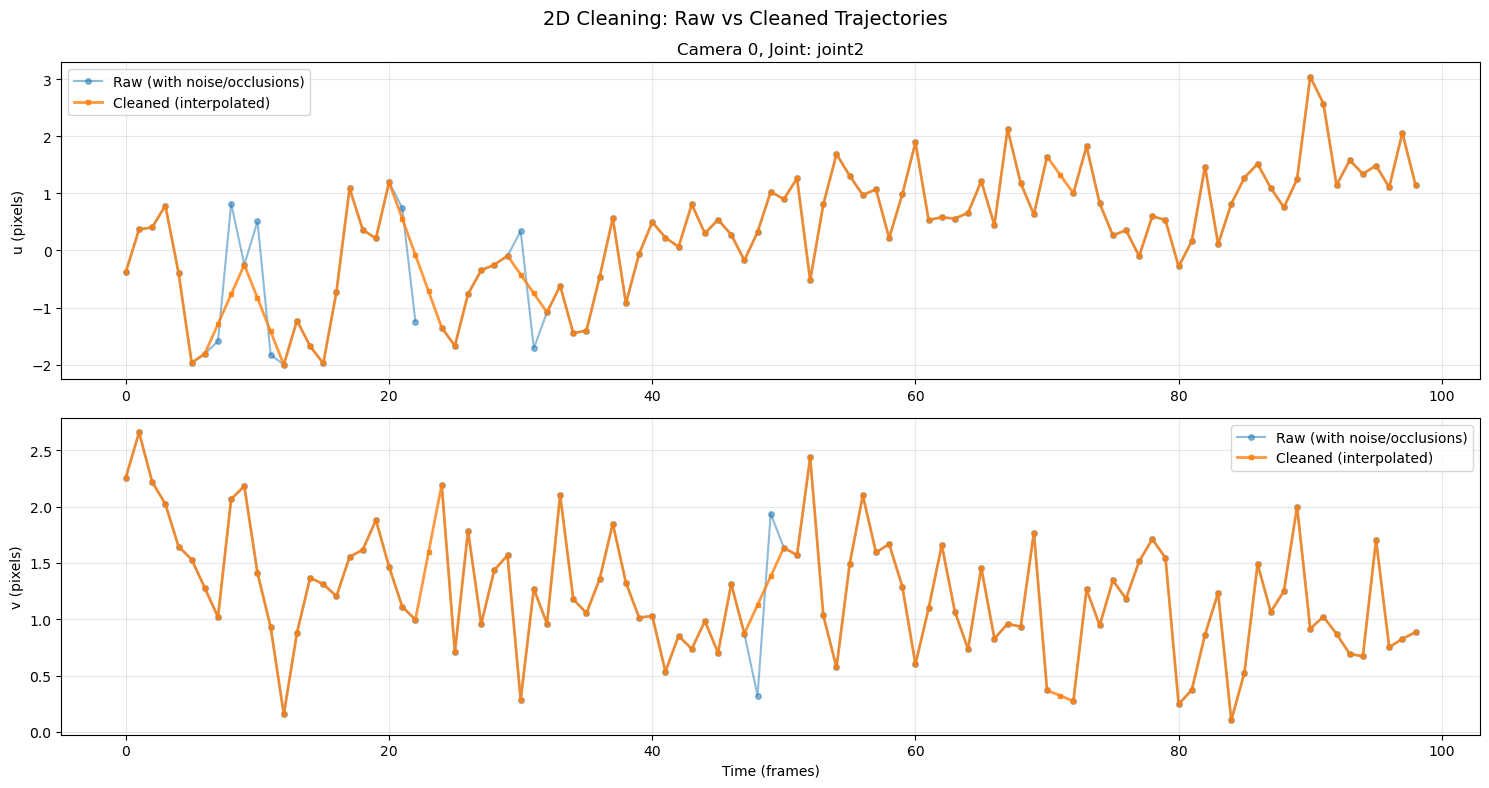


For joint2 in camera 0:
  NaN pixels before cleaning: 6
  NaN pixels after cleaning: 2
  Interpolated: 4 pixels


In [9]:
# Plot trajectory of one joint across time for one camera
camera_idx = 0
joint_idx = 2  # Pick an interesting joint (not root)
joint_name = DEMO_V0_1_SKELETON.joint_names[joint_idx]

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Extract trajectories
y_raw = y_observed_2d[camera_idx, :, joint_idx, :]      # (T, 2)
y_clean = y_cleaned_2d[camera_idx, :, joint_idx, :]     # (T, 2)

time_steps = np.arange(data.config.T)

# Plot X coordinate (u)
ax = axes[0]
ax.plot(time_steps, y_raw[:, 0], 'o-', alpha=0.5, label='Raw (with noise/occlusions)', markersize=4)
ax.plot(time_steps, y_clean[:, 0], 's-', alpha=0.8, label='Cleaned (interpolated)', markersize=3, linewidth=2)
ax.set_ylabel('u (pixels)')
ax.set_title(f'Camera {camera_idx}, Joint: {joint_name}')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot Y coordinate (v)
ax = axes[1]
ax.plot(time_steps, y_raw[:, 1], 'o-', alpha=0.5, label='Raw (with noise/occlusions)', markersize=4)
ax.plot(time_steps, y_clean[:, 1], 's-', alpha=0.8, label='Cleaned (interpolated)', markersize=3, linewidth=2)
ax.set_xlabel('Time (frames)')
ax.set_ylabel('v (pixels)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('2D Cleaning: Raw vs Cleaned Trajectories', fontsize=14)
plt.tight_layout()
plt.show()

# Show statistics
n_occluded_before = np.sum(np.isnan(y_raw))
n_occluded_after = np.sum(np.isnan(y_clean))
print(f"\nFor {joint_name} in camera {camera_idx}:")
print(f"  NaN pixels before cleaning: {n_occluded_before}")
print(f"  NaN pixels after cleaning: {n_occluded_after}")
print(f"  Interpolated: {n_occluded_before - n_occluded_after} pixels")

## 4. Step 2: Triangulate to 3D

Use Direct Linear Transform (DLT) to reconstruct 3D positions from multiple camera views.

In [10]:
print("Triangulating 2D → 3D...")
positions_3d = triangulate_multi_view(
    y_cleaned_2d,
    camera_proj,
    condition_threshold=1e6,  # Reject ill-conditioned solutions
)

print(f"\n✓ Triangulation complete:")
print(f"  Output shape: {positions_3d.shape}")
print(f"  Valid 3D points: {np.sum(~np.isnan(positions_3d[:, :, 0]))} / {positions_3d.shape[0] * positions_3d.shape[1]}")

Triangulating 2D → 3D...

✓ Triangulation complete:
  Output shape: (100, 6, 3)
  Valid 3D points: 593 / 600


### Visualize Triangulation Results: Ground Truth vs Reconstructed

Compare the triangulated 3D skeleton to ground truth at multiple timesteps.

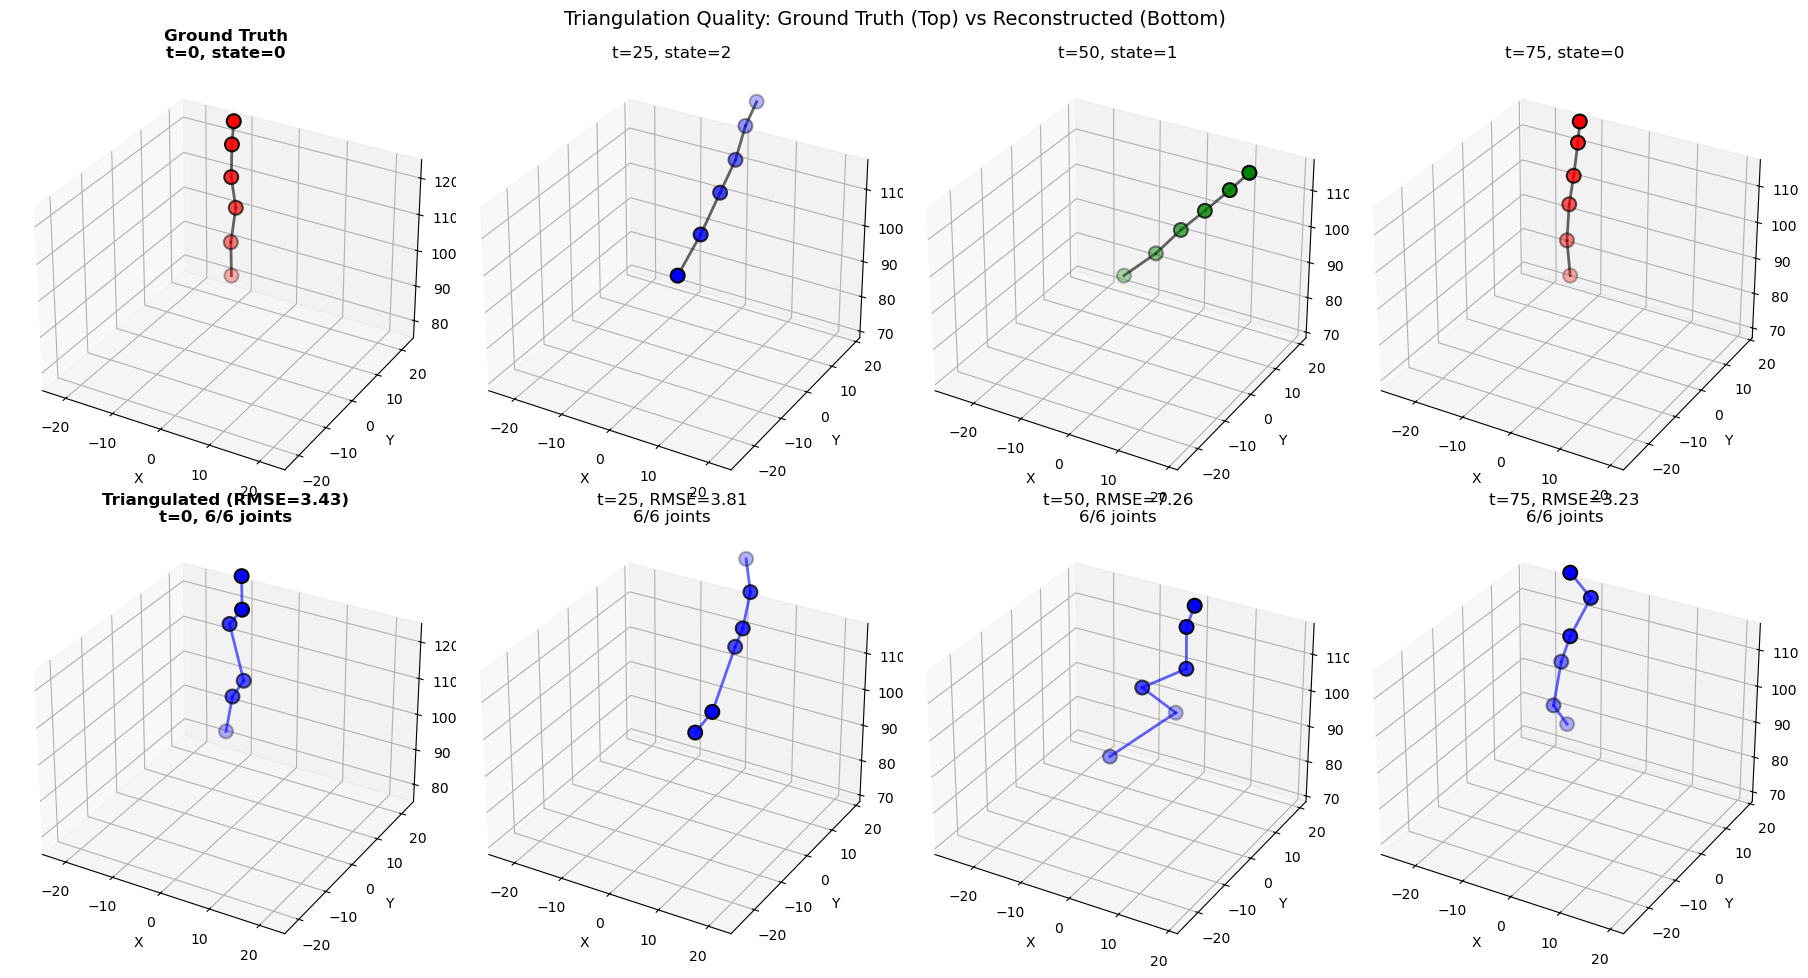


Triangulation error summary:
  t=  0: RMSE=3.433, max=4.275, valid=6/6 joints
  t= 25: RMSE=3.812, max=6.002, valid=6/6 joints
  t= 50: RMSE=7.258, max=11.378, valid=6/6 joints
  t= 75: RMSE=3.228, max=3.913, valid=6/6 joints


In [11]:
# Visualize ground truth vs triangulated 3D skeletons
fig = plt.figure(figsize=(18, 10))

timesteps_to_plot = [0, 25, 50, 75]
colors_by_state = ['red', 'green', 'blue']

# Top row: Ground Truth
for idx, t in enumerate(timesteps_to_plot, 1):
    ax = fig.add_subplot(2, 4, idx, projection='3d')
    
    x_t = data.x_true[t]  # (K, 3)
    state_t = data.true_states[t]
    
    # Plot skeleton bones
    for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
        if parent_idx >= 0:
            parent_pos = x_t[parent_idx]
            child_pos = x_t[k]
            ax.plot([parent_pos[0], child_pos[0]], 
                   [parent_pos[1], child_pos[1]], 
                   [parent_pos[2], child_pos[2]], 
                   'k-', linewidth=2, alpha=0.6)
    
    # Plot joints
    ax.scatter(x_t[:, 0], x_t[:, 1], x_t[:, 2], 
              c=colors_by_state[state_t], s=100, 
              edgecolors='black', linewidth=1.5, zorder=10)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    if idx == 1:
        ax.set_title(f'Ground Truth\nt={t}, state={state_t}', fontweight='bold')
    else:
        ax.set_title(f't={t}, state={state_t}')
    
    # Set equal aspect ratio
    center = x_t[0]
    max_range = 25
    ax.set_xlim([center[0] - max_range, center[0] + max_range])
    ax.set_ylim([center[1] - max_range, center[1] + max_range])
    ax.set_zlim([center[2] - max_range, center[2] + max_range])

# Bottom row: Triangulated
for idx, t in enumerate(timesteps_to_plot, 1):
    ax = fig.add_subplot(2, 4, 4 + idx, projection='3d')
    
    x_tri = positions_3d[t]  # (K, 3)
    x_gt = data.x_true[t]
    state_t = data.true_states[t]
    
    # Plot skeleton bones
    for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
        if parent_idx >= 0:
            parent_pos = x_tri[parent_idx]
            child_pos = x_tri[k]
            
            if not np.any(np.isnan(parent_pos)) and not np.any(np.isnan(child_pos)):
                ax.plot([parent_pos[0], child_pos[0]], 
                       [parent_pos[1], child_pos[1]], 
                       [parent_pos[2], child_pos[2]], 
                       'b-', linewidth=2, alpha=0.6)
    
    # Plot joints
    valid_joints = ~np.isnan(x_tri[:, 0])
    ax.scatter(x_tri[valid_joints, 0], 
              x_tri[valid_joints, 1], 
              x_tri[valid_joints, 2], 
              c='blue', s=100, edgecolors='black', linewidth=1.5, zorder=10)
    
    # Mark NaN joints
    nan_joints = np.isnan(x_tri[:, 0])
    if np.any(nan_joints):
        ax.scatter([], [], c='gray', s=100, marker='x', label='Failed triangulation')
    
    # Compute and display reconstruction error
    errors = np.linalg.norm(x_tri - x_gt, axis=1)
    mean_error = np.nanmean(errors)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    if idx == 1:
        title = f'Triangulated (RMSE={mean_error:.2f})\nt={t}, {np.sum(valid_joints)}/{len(valid_joints)} joints'
        ax.set_title(title, fontweight='bold')
        if np.any(nan_joints):
            ax.legend(fontsize=8)
    else:
        ax.set_title(f't={t}, RMSE={mean_error:.2f}\n{np.sum(valid_joints)}/{len(valid_joints)} joints')
    
    # Use same axis limits as ground truth
    center = x_gt[0]
    max_range = 25
    ax.set_xlim([center[0] - max_range, center[0] + max_range])
    ax.set_ylim([center[1] - max_range, center[1] + max_range])
    ax.set_zlim([center[2] - max_range, center[2] + max_range])

plt.suptitle('Triangulation Quality: Ground Truth (Top) vs Reconstructed (Bottom)', fontsize=14)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTriangulation error summary:")
for t in timesteps_to_plot:
    errors = np.linalg.norm(positions_3d[t] - data.x_true[t], axis=1)
    valid = ~np.isnan(errors)
    print(f"  t={t:3d}: RMSE={np.nanmean(errors):.3f}, max={np.nanmax(errors):.3f}, valid={np.sum(valid)}/{len(valid)} joints")

## 5. Step 3: Clean 3D Positions

Apply the same outlier detection to 3D positions to get clean data for statistics.

In [12]:
print("Cleaning 3D positions...")
positions_3d_clean, valid_frame_mask, use_for_stats, stats_3d = clean_keypoints_3d(
    positions_3d,
    DEMO_V0_1_SKELETON.parents,
    cleaning_config,
)

print(f"\n✓ 3D cleaning complete:")
print(f"  Jump outliers detected: {stats_3d['n_jump_outliers']}")
print(f"  Bone length outliers detected: {stats_3d['n_bone_outliers']}")
print(f"  Interpolated points: {stats_3d['n_interpolated']}")
print(f"  Invalid frames: {stats_3d['n_invalid_frames']}")
print(f"  Valid for statistics: {np.sum(use_for_stats)} samples")

Cleaning 3D positions...

✓ 3D cleaning complete:
  Jump outliers detected: 0
  Bone length outliers detected: 6
  Interpolated points: 18
  Invalid frames: 1
  Valid for statistics: 587 samples


### Visualize 3D Cleaning Results: Before vs After

Compare triangulated positions before and after 3D cleaning at multiple timesteps.

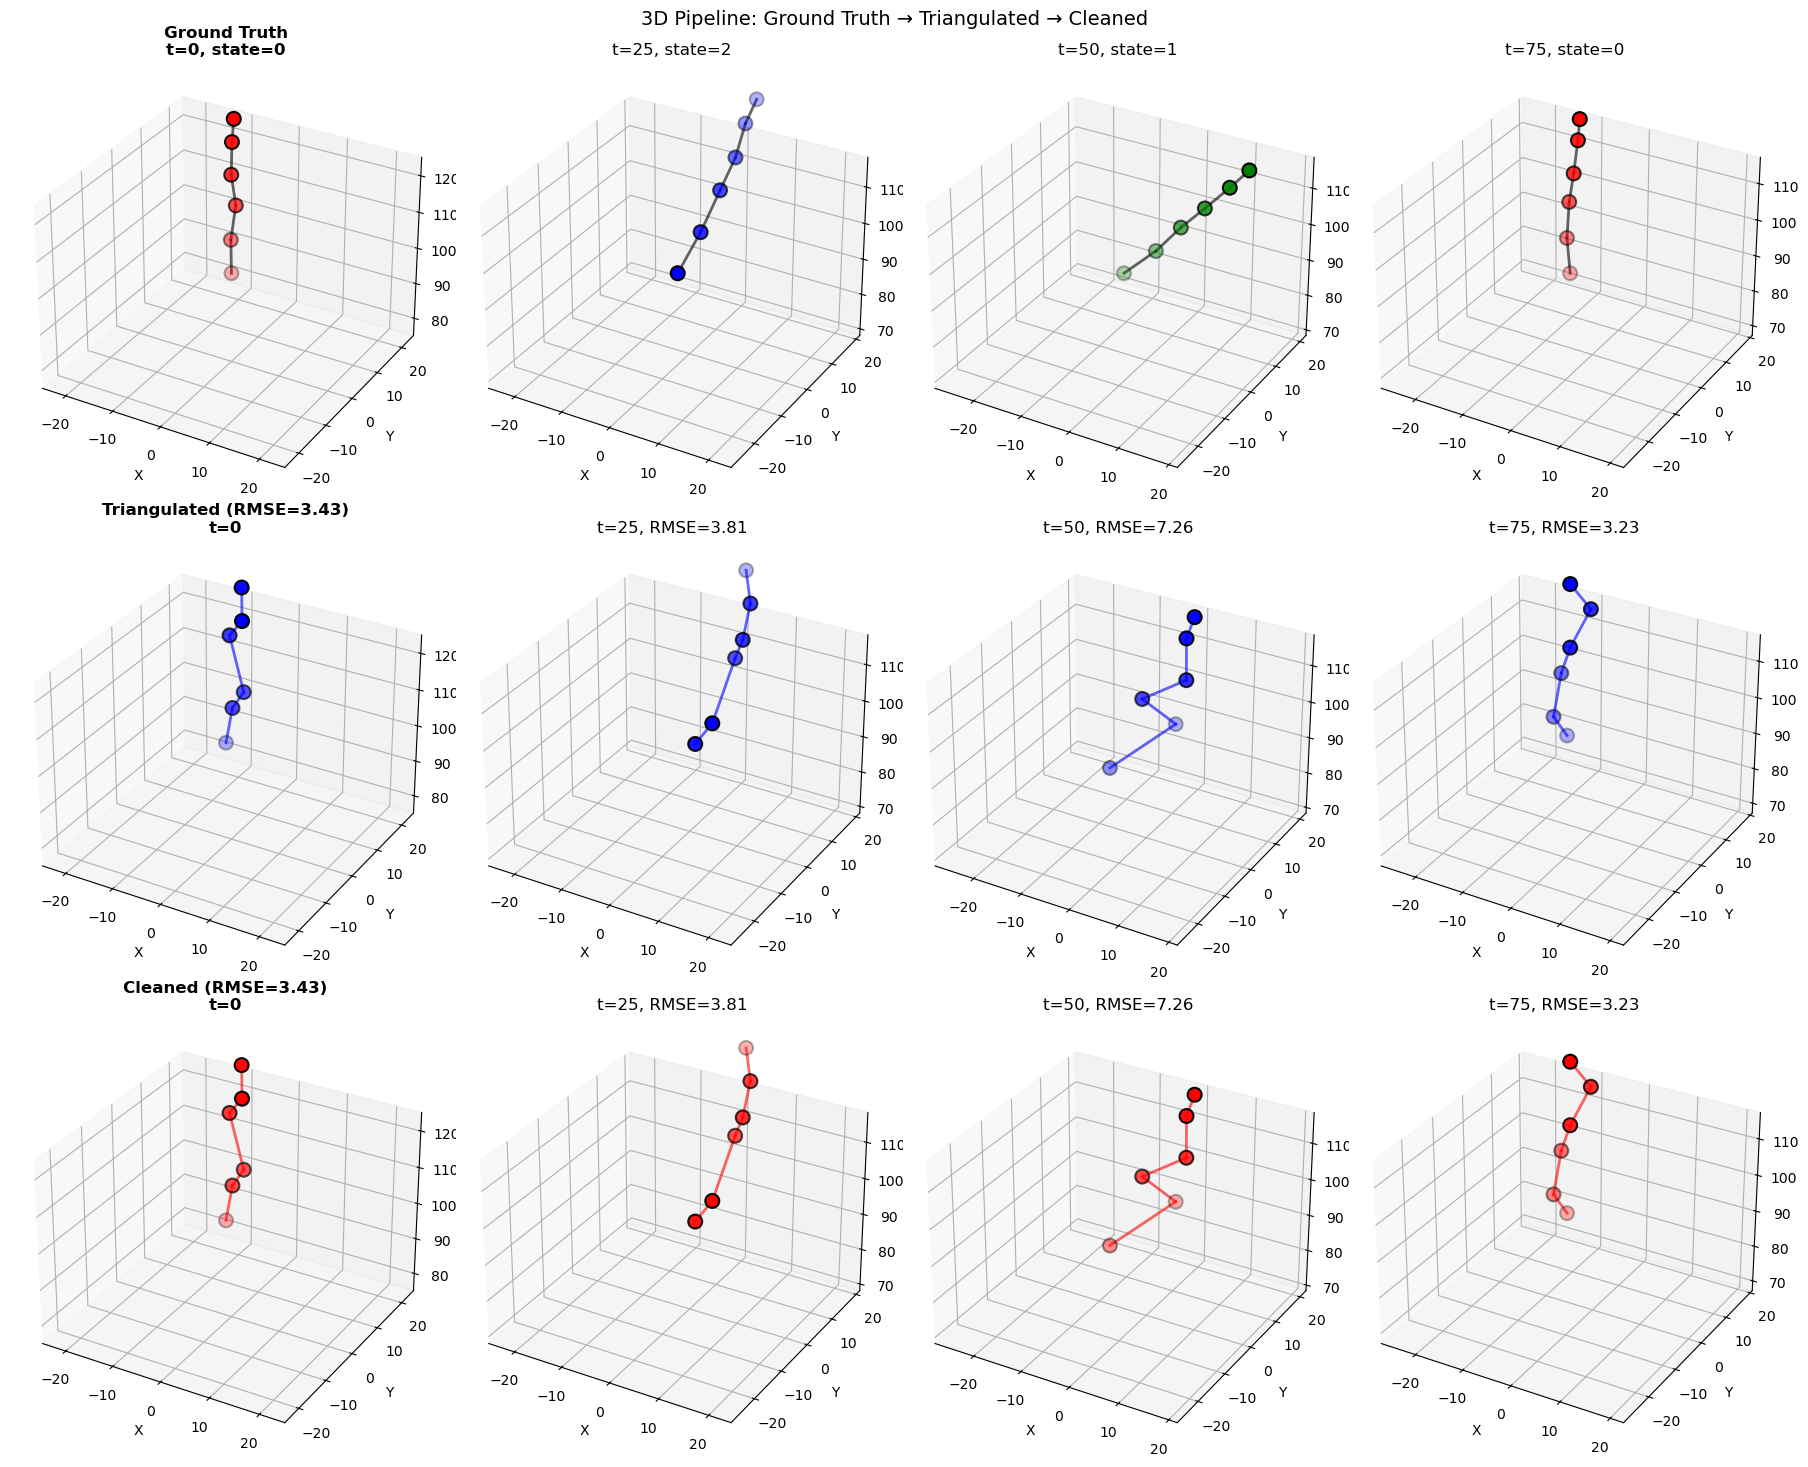


Reconstruction error comparison:
  Timestep  | Triangulated RMSE | Cleaned RMSE | Improvement
  --------------------------------------------------------------
  t=  0     |       3.433       |     3.433     |    0.0%
  t= 25     |       3.812       |     3.812     |    0.0%
  t= 50     |       7.258       |     7.258     |    0.0%
  t= 75     |       3.228       |     3.228     |    0.0%


In [13]:
# Visualize triangulated vs cleaned 3D skeletons
fig = plt.figure(figsize=(18, 15))

timesteps_to_plot = [0, 25, 50, 75]
colors_by_state = ['red', 'green', 'blue']

# Row 1: Ground Truth
for idx, t in enumerate(timesteps_to_plot, 1):
    ax = fig.add_subplot(3, 4, idx, projection='3d')
    
    x_t = data.x_true[t]  # (K, 3)
    state_t = data.true_states[t]
    
    # Plot skeleton bones
    for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
        if parent_idx >= 0:
            parent_pos = x_t[parent_idx]
            child_pos = x_t[k]
            ax.plot([parent_pos[0], child_pos[0]], 
                   [parent_pos[1], child_pos[1]], 
                   [parent_pos[2], child_pos[2]], 
                   'k-', linewidth=2, alpha=0.6)
    
    # Plot joints
    ax.scatter(x_t[:, 0], x_t[:, 1], x_t[:, 2], 
              c=colors_by_state[state_t], s=100, 
              edgecolors='black', linewidth=1.5, zorder=10)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    if idx == 1:
        ax.set_title(f'Ground Truth\nt={t}, state={state_t}', fontweight='bold')
    else:
        ax.set_title(f't={t}, state={state_t}')
    
    # Set equal aspect ratio
    center = x_t[0]
    max_range = 25
    ax.set_xlim([center[0] - max_range, center[0] + max_range])
    ax.set_ylim([center[1] - max_range, center[1] + max_range])
    ax.set_zlim([center[2] - max_range, center[2] + max_range])

# Row 2: Triangulated (before cleaning)
for idx, t in enumerate(timesteps_to_plot, 1):
    ax = fig.add_subplot(3, 4, 4 + idx, projection='3d')
    
    x_tri = positions_3d[t]  # (K, 3)
    x_gt = data.x_true[t]
    
    # Plot skeleton bones
    for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
        if parent_idx >= 0:
            parent_pos = x_tri[parent_idx]
            child_pos = x_tri[k]
            
            if not np.any(np.isnan(parent_pos)) and not np.any(np.isnan(child_pos)):
                ax.plot([parent_pos[0], child_pos[0]], 
                       [parent_pos[1], child_pos[1]], 
                       [parent_pos[2], child_pos[2]], 
                       'b-', linewidth=2, alpha=0.6)
    
    # Plot joints
    valid_joints = ~np.isnan(x_tri[:, 0])
    ax.scatter(x_tri[valid_joints, 0], 
              x_tri[valid_joints, 1], 
              x_tri[valid_joints, 2], 
              c='blue', s=100, edgecolors='black', linewidth=1.5, zorder=10)
    
    # Compute error
    errors = np.linalg.norm(x_tri - x_gt, axis=1)
    mean_error = np.nanmean(errors)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    if idx == 1:
        ax.set_title(f'Triangulated (RMSE={mean_error:.2f})\nt={t}', fontweight='bold')
    else:
        ax.set_title(f't={t}, RMSE={mean_error:.2f}')
    
    center = x_gt[0]
    max_range = 25
    ax.set_xlim([center[0] - max_range, center[0] + max_range])
    ax.set_ylim([center[1] - max_range, center[1] + max_range])
    ax.set_zlim([center[2] - max_range, center[2] + max_range])

# Row 3: Cleaned
for idx, t in enumerate(timesteps_to_plot, 1):
    ax = fig.add_subplot(3, 4, 8 + idx, projection='3d')
    
    x_clean = positions_3d_clean[t]  # (K, 3)
    x_gt = data.x_true[t]
    
    # Plot skeleton bones
    for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
        if parent_idx >= 0:
            parent_pos = x_clean[parent_idx]
            child_pos = x_clean[k]
            
            if not np.any(np.isnan(parent_pos)) and not np.any(np.isnan(child_pos)):
                ax.plot([parent_pos[0], child_pos[0]], 
                       [parent_pos[1], child_pos[1]], 
                       [parent_pos[2], child_pos[2]], 
                       'r-', linewidth=2, alpha=0.6)
    
    # Plot joints
    valid_joints = ~np.isnan(x_clean[:, 0])
    ax.scatter(x_clean[valid_joints, 0], 
              x_clean[valid_joints, 1], 
              x_clean[valid_joints, 2], 
              c='red', s=100, edgecolors='black', linewidth=1.5, zorder=10)
    
    # Compute error
    errors = np.linalg.norm(x_clean - x_gt, axis=1)
    mean_error = np.nanmean(errors)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    if idx == 1:
        ax.set_title(f'Cleaned (RMSE={mean_error:.2f})\nt={t}', fontweight='bold')
    else:
        ax.set_title(f't={t}, RMSE={mean_error:.2f}')
    
    center = x_gt[0]
    max_range = 25
    ax.set_xlim([center[0] - max_range, center[0] + max_range])
    ax.set_ylim([center[1] - max_range, center[1] + max_range])
    ax.set_zlim([center[2] - max_range, center[2] + max_range])

plt.suptitle('3D Pipeline: Ground Truth → Triangulated → Cleaned', fontsize=14)
plt.tight_layout()
plt.show()

# Print comparison statistics
print("\nReconstruction error comparison:")
print("  Timestep  | Triangulated RMSE | Cleaned RMSE | Improvement")
print("  " + "-" * 62)
for t in timesteps_to_plot:
    err_tri = np.nanmean(np.linalg.norm(positions_3d[t] - data.x_true[t], axis=1))
    err_cln = np.nanmean(np.linalg.norm(positions_3d_clean[t] - data.x_true[t], axis=1))
    improvement = ((err_tri - err_cln) / err_tri * 100) if err_tri > 0 else 0
    print(f"  t={t:3d}     |      {err_tri:6.3f}       |    {err_cln:6.3f}     | {improvement:6.1f}%")

### Visualize 3D Reconstruction and Cleaning

Compare triangulated 3D positions before and after cleaning.

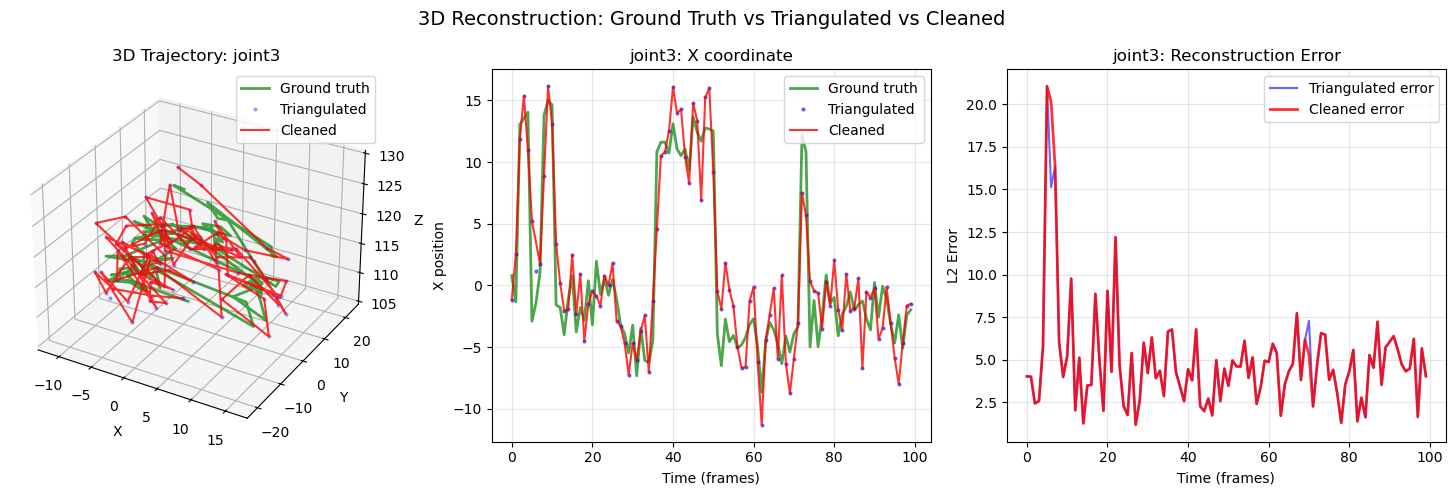


joint3 reconstruction error:
  Triangulated: mean=4.840, std=2.981
  Cleaned:      mean=4.870, std=3.180


In [14]:
# Plot 3D trajectory of one joint across time
fig = plt.figure(figsize=(15, 5))

# Joint to visualize
joint_idx = 3
joint_name = DEMO_V0_1_SKELETON.joint_names[joint_idx]

# Extract trajectories
x_true = data.x_true[:, joint_idx, :]           # (T, 3) - ground truth
x_triangulated = positions_3d[:, joint_idx, :]  # (T, 3) - after triangulation
x_cleaned = positions_3d_clean[:, joint_idx, :] # (T, 3) - after 3D cleaning

# 3D trajectory plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot(x_true[:, 0], x_true[:, 1], x_true[:, 2], 
       'g-', linewidth=2, alpha=0.7, label='Ground truth')
ax.plot(x_triangulated[:, 0], x_triangulated[:, 1], x_triangulated[:, 2], 
       'b.', alpha=0.3, markersize=4, label='Triangulated')
ax.plot(x_cleaned[:, 0], x_cleaned[:, 1], x_cleaned[:, 2], 
       'r-', linewidth=1.5, alpha=0.8, label='Cleaned')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Trajectory: {joint_name}')
ax.legend()

# X coordinate over time
ax = fig.add_subplot(1, 3, 2)
ax.plot(time_steps, x_true[:, 0], 'g-', linewidth=2, alpha=0.7, label='Ground truth')
ax.plot(time_steps, x_triangulated[:, 0], 'b.', alpha=0.5, markersize=4, label='Triangulated')
ax.plot(time_steps, x_cleaned[:, 0], 'r-', linewidth=1.5, alpha=0.8, label='Cleaned')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('X position')
ax.set_title(f'{joint_name}: X coordinate')
ax.legend()
ax.grid(True, alpha=0.3)

# Reconstruction error over time
ax = fig.add_subplot(1, 3, 3)
error_triangulated = np.linalg.norm(x_triangulated - x_true, axis=1)
error_cleaned = np.linalg.norm(x_cleaned - x_true, axis=1)
ax.plot(time_steps, error_triangulated, 'b-', alpha=0.6, label='Triangulated error')
ax.plot(time_steps, error_cleaned, 'r-', linewidth=2, alpha=0.8, label='Cleaned error')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('L2 Error')
ax.set_title(f'{joint_name}: Reconstruction Error')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('3D Reconstruction: Ground Truth vs Triangulated vs Cleaned', fontsize=14)
plt.tight_layout()
plt.show()

# Print error statistics
valid_triangulated = ~np.isnan(error_triangulated)
valid_cleaned = ~np.isnan(error_cleaned)
print(f"\n{joint_name} reconstruction error:")
print(f"  Triangulated: mean={np.nanmean(error_triangulated):.3f}, std={np.nanstd(error_triangulated):.3f}")
print(f"  Cleaned:      mean={np.nanmean(error_cleaned):.3f}, std={np.nanstd(error_cleaned):.3f}")

### Compare Full Skeleton: Ground Truth vs Reconstructed

Side-by-side comparison of the complete skeleton at one timestep.

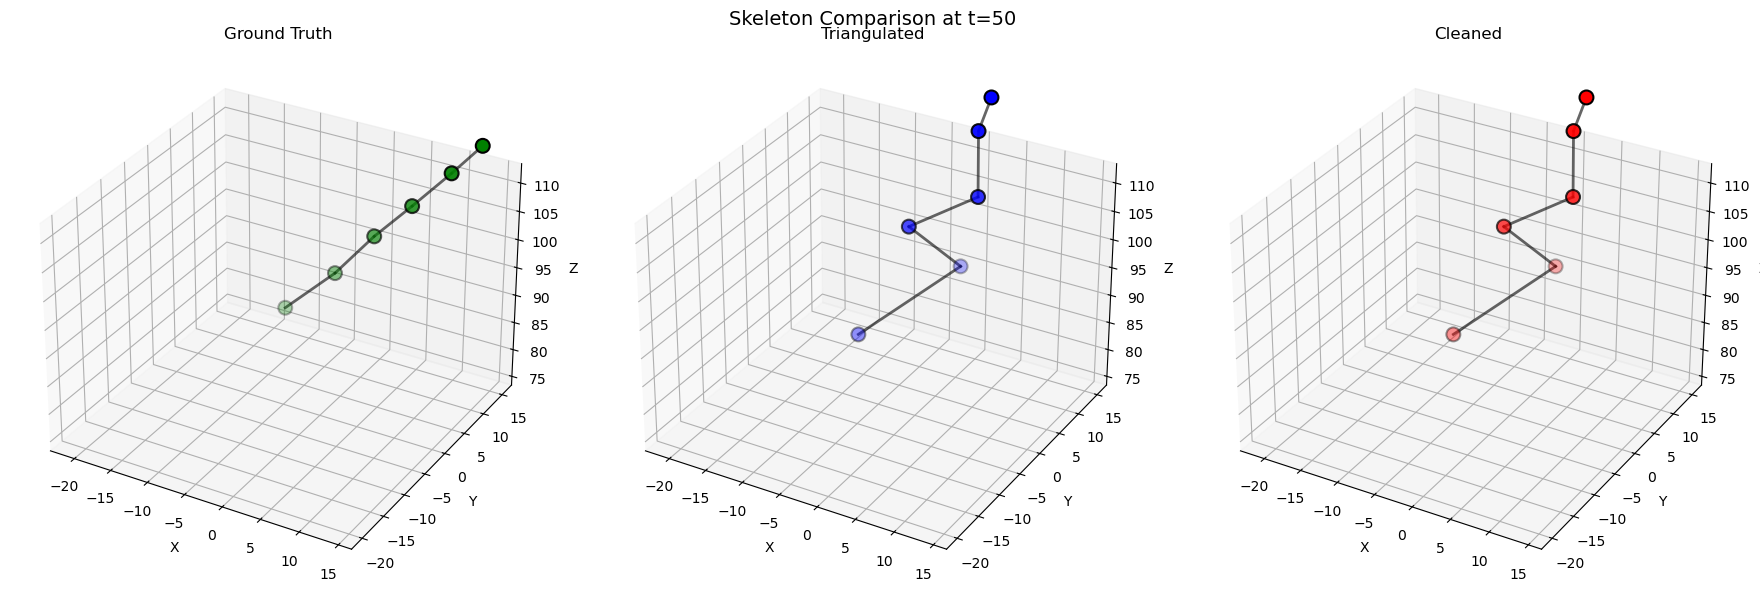


Reconstruction error at t=50:
  Triangulated: mean=7.258, max=11.378
  Cleaned:      mean=7.258, max=11.378
  Valid joints (triangulated): 6 / 6
  Valid joints (cleaned):      6 / 6


In [15]:
# Compare skeletons at one timestep
fig = plt.figure(figsize=(18, 6))

t_compare = 50

for idx, (x_data, title, color) in enumerate([
    (data.x_true[t_compare], 'Ground Truth', 'green'),
    (positions_3d[t_compare], 'Triangulated', 'blue'),
    (positions_3d_clean[t_compare], 'Cleaned', 'red'),
], 1):
    ax = fig.add_subplot(1, 3, idx, projection='3d')
    
    # Plot skeleton bones
    for k, parent_idx in enumerate(DEMO_V0_1_SKELETON.parents):
        if parent_idx >= 0:
            parent_pos = x_data[parent_idx]
            child_pos = x_data[k]
            
            # Skip if NaN
            if not np.any(np.isnan(parent_pos)) and not np.any(np.isnan(child_pos)):
                ax.plot([parent_pos[0], child_pos[0]], 
                       [parent_pos[1], child_pos[1]], 
                       [parent_pos[2], child_pos[2]], 
                       'k-', linewidth=2, alpha=0.6)
    
    # Plot joints
    valid_joints = ~np.isnan(x_data[:, 0])
    ax.scatter(x_data[valid_joints, 0], 
              x_data[valid_joints, 1], 
              x_data[valid_joints, 2], 
              c=color, s=100, edgecolors='black', linewidth=1.5, zorder=10)
    
    # Mark any NaN joints
    nan_joints = np.isnan(x_data[:, 0])
    if np.any(nan_joints):
        ax.scatter([], [], c='gray', s=100, marker='x', label=f'{np.sum(nan_joints)} NaN joints')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    if np.any(nan_joints):
        ax.legend()
    
    # Set equal aspect ratio based on ground truth
    center = data.x_true[t_compare, 0]  # Root position
    max_range = 20
    ax.set_xlim([center[0] - max_range, center[0] + max_range])
    ax.set_ylim([center[1] - max_range, center[1] + max_range])
    ax.set_zlim([center[2] - max_range, center[2] + max_range])

plt.suptitle(f'Skeleton Comparison at t={t_compare}', fontsize=14)
plt.tight_layout()
plt.show()

# Compute overall reconstruction error
x_gt = data.x_true[t_compare]
x_tri = positions_3d[t_compare]
x_cln = positions_3d_clean[t_compare]

error_tri = np.linalg.norm(x_tri - x_gt, axis=1)
error_cln = np.linalg.norm(x_cln - x_gt, axis=1)

print(f"\nReconstruction error at t={t_compare}:")
print(f"  Triangulated: mean={np.nanmean(error_tri):.3f}, max={np.nanmax(error_tri):.3f}")
print(f"  Cleaned:      mean={np.nanmean(error_cln):.3f}, max={np.nanmax(error_cln):.3f}")
print(f"  Valid joints (triangulated): {np.sum(~np.isnan(error_tri))} / {len(error_tri)}")
print(f"  Valid joints (cleaned):      {np.sum(~np.isnan(error_cln))} / {len(error_cln)}")

## 6. Step 4: Compute Directional Statistics

For each joint, compute:
- **Mean direction** $\bar{\mu}$: Average unit vector
- **Concentration** $\kappa$: von Mises-Fisher concentration parameter

These represent the empirical distribution of bone directions in the dataset.

In [16]:
print("Computing directional statistics...")
empirical_stats = compute_direction_statistics(
    positions_3d_clean,
    DEMO_V0_1_SKELETON.parents,
    use_for_stats,
    DEMO_V0_1_SKELETON.joint_names,
    min_samples=10,  # Require at least 10 samples per joint
)

print(f"\n✓ Statistics computed:")
print(f"  Joints with valid statistics: {len(empirical_stats)} / {len(DEMO_V0_1_SKELETON.joint_names)}")

for joint_name, stats in empirical_stats.items():
    print(f"\n  {joint_name}:")
    print(f"    Samples: {stats['n_samples']}")
    print(f"    Mean direction: [{stats['mu'][0]:.2f}, {stats['mu'][1]:.2f}, {stats['mu'][2]:.2f}]")
    print(f"    Concentration (kappa): {stats['kappa']:.2f}")

Computing directional statistics...

✓ Statistics computed:
  Joints with valid statistics: 6 / 6

  root:
    Samples: 0
    Mean direction: [nan, nan, nan]
    Concentration (kappa): nan

  joint1:
    Samples: 97
    Mean direction: [0.10, 0.14, 0.99]
    Concentration (kappa): 4.82

  joint2:
    Samples: 97
    Mean direction: [0.16, 0.13, 0.98]
    Concentration (kappa): 6.09

  joint3:
    Samples: 97
    Mean direction: [0.20, 0.10, 0.97]
    Concentration (kappa): 3.74

  joint4:
    Samples: 96
    Mean direction: [0.12, 0.07, 0.99]
    Concentration (kappa): 3.45

  joint5:
    Samples: 96
    Mean direction: [0.13, 0.35, 0.93]
    Concentration (kappa): 2.69


### Visualize Empirical Distributions

Plot the empirical bone directions in 3D space.

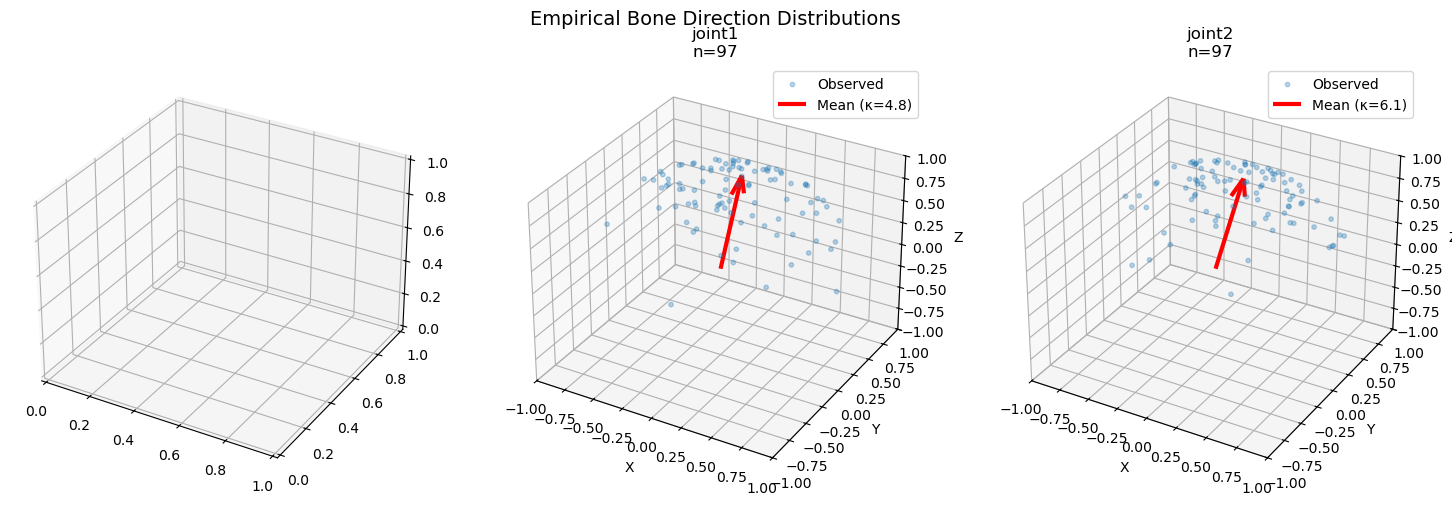

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 5))

# Plot empirical directions for first 3 joints
joint_names_to_plot = list(empirical_stats.keys())[:3]

for idx, joint_name in enumerate(joint_names_to_plot, 1):
    ax = fig.add_subplot(1, 3, idx, projection='3d')
    
    stats = empirical_stats[joint_name]
    
    # Extract all direction samples for this joint
    T, K, _ = positions_3d_clean.shape
    k = DEMO_V0_1_SKELETON.joint_names.index(joint_name)
    parent_idx = DEMO_V0_1_SKELETON.parents[k]
    
    if parent_idx >= 0:
        directions = []
        for t in range(T):
            if use_for_stats[t, k] and use_for_stats[t, parent_idx]:
                child_pos = positions_3d_clean[t, k, :]
                parent_pos = positions_3d_clean[t, parent_idx, :]
                if not np.any(np.isnan(child_pos)) and not np.any(np.isnan(parent_pos)):
                    bone_vec = child_pos - parent_pos
                    bone_length = np.linalg.norm(bone_vec)
                    if bone_length > 1e-6:
                        direction = bone_vec / bone_length
                        directions.append(direction)
        
        directions = np.array(directions)
        
        # Plot scatter of directions
        ax.scatter(directions[:, 0], directions[:, 1], directions[:, 2], 
                  alpha=0.3, s=10, label='Observed')
        
        # Plot mean direction
        mu = stats['mu']
        ax.quiver(0, 0, 0, mu[0], mu[1], mu[2], 
                 color='red', arrow_length_ratio=0.2, linewidth=3, label=f'Mean (κ={stats["kappa"]:.1f})')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'{joint_name}\nn={stats["n_samples"]}')
        ax.legend()
        
        # Set equal aspect ratio
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])

plt.suptitle('Empirical Bone Direction Distributions', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Step 5: Build Prior Configuration

Convert empirical statistics to PyMC prior parameters:

- **Direction prior**: Projected Normal with learned mean and SD
- **Concentration prior**: Gamma distribution with learned mode and SD

In [18]:
print("Building prior configuration...")
prior_config = build_priors_from_statistics(
    empirical_stats,
    DEMO_V0_1_SKELETON.joint_names,
    kappa_scale=5.0,  # Inflate uncertainty by 5x
)

print(f"\n✓ Prior configuration built:")
print(f"  Priors created for {len(prior_config)} joints")

for joint_name, prior in prior_config.items():
    print(f"\n  {joint_name}:")
    print(f"    mu_mean: [{prior['mu_mean'][0]:.2f}, {prior['mu_mean'][1]:.2f}, {prior['mu_mean'][2]:.2f}]")
    print(f"    mu_sd: {prior['mu_sd']:.3f}")
    print(f"    kappa_mode: {prior['kappa_mode']:.3f}")
    print(f"    kappa_sd: {prior['kappa_sd']:.3f}")

Building prior configuration...

✓ Prior configuration built:
  Priors created for 5 joints

  joint1:
    mu_mean: [0.10, 0.14, 0.99]
    mu_sd: 1.019
    kappa_mode: 0.964
    kappa_sd: 0.482

  joint2:
    mu_mean: [0.16, 0.13, 0.98]
    mu_sd: 0.906
    kappa_mode: 1.218
    kappa_sd: 0.609

  joint3:
    mu_mean: [0.20, 0.10, 0.97]
    mu_sd: 1.156
    kappa_mode: 0.748
    kappa_sd: 0.374

  joint4:
    mu_mean: [0.12, 0.07, 0.99]
    mu_sd: 1.204
    kappa_mode: 0.690
    kappa_sd: 0.345

  joint5:
    mu_mean: [0.13, 0.35, 0.93]
    mu_sd: 1.363
    kappa_mode: 0.539
    kappa_sd: 0.269


## 8. Build PyMC Models: v0.1 vs v0.2.1

We'll build two models side-by-side:
- **v0.1**: Uninformative priors (baseline)
- **v0.2.1**: Data-driven priors

Then compare their convergence and ESS.

### 8a. Model v0.1 (Uninformative Priors)

In [19]:
print("Building v0.1 model (uninformative priors)...")

# Initialize parameters from ground truth
init_result = initialize_from_groundtruth(
    x_gt=data.x_true,
    parents=DEMO_V0_1_SKELETON.parents,
)

# Build complete model with uninformative priors (no HMM)
with pm.Model() as model_v0_1:
    build_camera_observation_model(
        y_observed=data.y_observed,
        camera_proj=data.camera_proj,
        parents=DEMO_V0_1_SKELETON.parents,
        init_result=init_result,
        use_mixture=True,
        use_directional_hmm=False,  # v0.1: no HMM priors
    )

print("\n✓ v0.1 Model built:")
print(f"  Total variables: {len(model_v0_1.unobserved_RVs)}")
print(f"  Priors: Uninformative (v0.1)")

Building v0.1 model (uninformative priors)...


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(



✓ v0.1 Model built:
  Total variables: 30
  Priors: Uninformative (v0.1)


### 🔍 Diagnostic: Check Initialization vs Prior Consistency

Before building models, let's verify that our initialization values are consistent with the default prior hyperparameters.

In [20]:
# Check initialization values against default priors
print("=" * 70)
print("INITIALIZATION vs PRIOR DIAGNOSTICS")
print("=" * 70)

# Default hyperparameters from pymc_model.py
default_hyperparams = {
    "eta2_root_sigma": 0.1,
    "rho_sigma": 2.0,
    "sigma2_sigma": 0.1,
    "obs_sigma_sigma": 10.0,
}

print("\n1. Root Random Walk Variance (eta2_root):")
print(f"   Init value:     {init_result.eta2[0]:.4f}")
print(f"   Prior: HalfNormal(σ={default_hyperparams['eta2_root_sigma']})")
print(f"   Expected range: [0, ~{3 * default_hyperparams['eta2_root_sigma']:.2f}]")
if init_result.eta2[0] > 3 * default_hyperparams['eta2_root_sigma']:
    print(f"   ⚠️  WARNING: Init value outside typical prior range!")

print("\n2. Bone Lengths (rho):")
print(f"   Init range:     [{init_result.rho.min():.2f}, {init_result.rho.max():.2f}]")
print(f"   Init mean:      {init_result.rho.mean():.2f}")
print(f"   Prior: HalfNormal(σ={default_hyperparams['rho_sigma']})")
print(f"   Expected range: [0, ~{3 * default_hyperparams['rho_sigma']:.1f}]")
if init_result.rho.max() > 3 * default_hyperparams['rho_sigma']:
    print(f"   ⚠️  WARNING: Some init values outside typical prior range!")

print("\n3. Bone Length Variance (sigma2):")
print(f"   Init range:     [{init_result.sigma2.min():.4f}, {init_result.sigma2.max():.4f}]")
print(f"   Init mean:      {init_result.sigma2.mean():.4f}")
print(f"   Prior: HalfNormal(σ={default_hyperparams['sigma2_sigma']})")
print(f"   Expected range: [0, ~{3 * default_hyperparams['sigma2_sigma']:.2f}]")
if init_result.sigma2.max() > 3 * default_hyperparams['sigma2_sigma']:
    print(f"   ⚠️  WARNING: Some init values outside typical prior range!")

print("\n4. Observation Noise (obs_sigma):")
print(f"   Init value:     {init_result.obs_sigma:.2f}")
print(f"   Prior: HalfNormal(σ={default_hyperparams['obs_sigma_sigma']})")
print(f"   Expected range: [0, ~{3 * default_hyperparams['obs_sigma_sigma']:.1f}]")

print("\n5. Direction Vectors (raw_u):")
print(f"   Prior: Normal(μ=0, σ=1.0) [sigma_dir parameter]")
print(f"   Note: Normalized to unit length after sampling")

print("\n" + "=" * 70)
print("RECOMMENDATION:")
print("=" * 70)
if (init_result.eta2[0] > 3 * default_hyperparams['eta2_root_sigma'] or 
    init_result.sigma2.max() > 3 * default_hyperparams['sigma2_sigma']):
    print("⚠️  Consider using relaxed priors with prior_hyperparams dict:")
    print("   prior_hyperparams = {")
    print(f"       'eta2_root_sigma': {max(init_result.eta2[0] / 2, 0.5):.1f},")
    print(f"       'sigma2_sigma': {max(init_result.sigma2.mean() * 2, 0.5):.1f},")
    print("   }")
else:
    print("✓ Initialization values are consistent with default priors")
print("=" * 70)

INITIALIZATION vs PRIOR DIAGNOSTICS

1. Root Random Walk Variance (eta2_root):
   Init value:     3.0472
   Prior: HalfNormal(σ=0.1)
   Expected range: [0, ~0.30]
   ⚠️  WARNING: Init value outside typical prior range!

2. Bone Lengths (rho):
   Init range:     [6.00, 10.00]
   Init mean:      8.40
   Prior: HalfNormal(σ=2.0)
   Expected range: [0, ~6.0]
   ⚠️  WARNING: Some init values outside typical prior range!

3. Bone Length Variance (sigma2):
   Init range:     [0.0001, 0.0001]
   Init mean:      0.0001
   Prior: HalfNormal(σ=0.1)
   Expected range: [0, ~0.30]

4. Observation Noise (obs_sigma):
   Init value:     2.00
   Prior: HalfNormal(σ=10.0)
   Expected range: [0, ~30.0]

5. Direction Vectors (raw_u):
   Prior: Normal(μ=0, σ=1.0) [sigma_dir parameter]
   Note: Normalized to unit length after sampling

RECOMMENDATION:
⚠️  Consider using relaxed priors with prior_hyperparams dict:
   prior_hyperparams = {
       'eta2_root_sigma': 1.5,
       'sigma2_sigma': 0.5,
   }


### 8b. Model v0.2.1 (Data-Driven Priors)

In [21]:
print("Building v0.2.1 model (data-driven priors)...")

# Build complete model with data-driven HMM priors
with pm.Model() as model_v0_2_1:
    build_camera_observation_model(
        y_observed=data.y_observed,
        camera_proj=data.camera_proj,
        parents=DEMO_V0_1_SKELETON.parents,
        init_result=init_result,
        use_mixture=True,
        use_directional_hmm=True,  # v0.2.1: enable HMM priors
        hmm_num_states=data.config.S,
        hmm_kwargs={
            'name_prefix': 'dir_hmm',
            'joint_names': DEMO_V0_1_SKELETON.joint_names,
            'prior_config': prior_config,  # Data-driven priors
        },
    )

print("\n✓ v0.2.1 Model built:")
print(f"  Total variables: {len(model_v0_2_1.unobserved_RVs)}")
print(f"  HMM states: {data.config.S}")
print(f"  Priors: Data-driven for {len(prior_config)} joints (v0.2.1)")

Building v0.2.1 model (data-driven priors)...


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(



✓ v0.2.1 Model built:
  Total variables: 75
  HMM states: 3
  Priors: Data-driven for 5 joints (v0.2.1)


## 9. Sample from Both Models

Run NUTS sampling for both models with identical settings.

In [22]:
# Sampling configuration
n_tune = 200
n_draws = 200
n_chains = 1

print(f"Sampling parameters:")
print(f"  Tune: {n_tune}, Draws: {n_draws}, Chains: {n_chains}")

Sampling parameters:
  Tune: 200, Draws: 200, Chains: 1


### 9a. Sample v0.1 Model

In [23]:
print("\nSampling v0.1 model (uninformative priors)...")
print("Using target_accept=0.95 to reduce divergences...\n")

with model_v0_1:
    trace_v0_1 = pm.sample(
        draws=n_draws,
        tune=n_tune,
        chains=n_chains,
        target_accept=0.95,
        return_inferencedata=True,
    )

print("\n✓ v0.1 sampling complete!")


Sampling v0.1 model (uninformative priors)...
Using target_accept=0.95 to reduce divergences...



c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob]
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob]


Output()

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 1 chain for 200 tune and 200 draw iterations (200 + 200 draws total) took 1 seconds.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks



✓ v0.1 sampling complete!


### 9b. Sample v0.2.1 Model

In [24]:
print("\nSampling v0.2.1 model (data-driven priors)...")
print("Using target_accept=0.95 to reduce divergences...\n")

with model_v0_2_1:
    trace_v0_2_1 = pm.sample(
        draws=n_draws,
        tune=n_tune,
        chains=n_chains,
        target_accept=0.95,
        return_inferencedata=True,
    )

print("\n✓ v0.2.1 sampling complete!")


Sampling v0.2.1 model (data-driven priors)...
Using target_accept=0.95 to reduce divergences...



c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob, dir_hmm_mu_raw_s0_k0, dir_hmm_mu_raw_s0_k1, dir_hmm_mu_raw_s0_k2, dir_hmm_mu_raw_s0_k3, dir_hmm_mu_raw_s0_k4, dir_hmm_mu_raw_s0_k5, dir_hmm_mu_raw_s1_k0, dir_hmm_mu_raw_s1_k1, dir_hmm_mu_raw_s1_k2, dir_hm

Output()

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 1 chain for 200 tune and 200 draw iterations (200 + 200 draws total) took 3 seconds.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks



✓ v0.2.1 sampling complete!


## 10. Compare Results

### 10a. Effective Sample Size (ESS)

ESS measures how many independent samples the MCMC chain is equivalent to. Higher is better.

In [25]:
# Compare ESS for common parameters that exist in both models
print("=" * 70)
print("ESS COMPARISON: v0.1 (no HMM) vs v0.2.1 (with HMM)")
print("=" * 70)

# Parameters that exist in both models
common_params = ['x_root', 'obs_sigma', 'eta2_root', 'rho']

for param in common_params:
    if param in trace_v0_1.posterior and param in trace_v0_2_1.posterior:
        ess_v0_1 = az.ess(trace_v0_1, var_names=[param])
        ess_v0_2_1 = az.ess(trace_v0_2_1, var_names=[param])
        
        # Get values
        vals_v0_1 = ess_v0_1.to_array().values.flatten()
        vals_v0_2_1 = ess_v0_2_1.to_array().values.flatten()
        
        print(f"\n{param}:")
        print(f"  v0.1:   mean={vals_v0_1.mean():6.1f}, min={vals_v0_1.min():6.1f}, max={vals_v0_1.max():6.1f}")
        print(f"  v0.2.1: mean={vals_v0_2_1.mean():6.1f}, min={vals_v0_2_1.min():6.1f}, max={vals_v0_2_1.max():6.1f}")
        
        if vals_v0_1.mean() > 0:
            improvement = ((vals_v0_2_1.mean() / vals_v0_1.mean()) - 1) * 100
            if improvement > 0:
                print(f"  → v0.2.1 improvement: +{improvement:.1f}%")
            else:
                print(f"  → v0.2.1 worse: {improvement:.1f}%")

# HMM parameters only in v0.2.1
print("\n" + "=" * 70)
print("HMM-SPECIFIC PARAMETERS (v0.2.1 only)")
print("=" * 70)

hmm_params = [v for v in trace_v0_2_1.posterior.data_vars if 'dir_hmm' in str(v)]
print(f"\nFound {len(hmm_params)} HMM parameters")

# Show ESS for key HMM parameters if they exist
for param in ['dir_hmm_mu', 'dir_hmm_kappa_full']:
    if param in trace_v0_2_1.posterior:
        ess = az.ess(trace_v0_2_1, var_names=[param])
        vals = ess.to_array().values.flatten()
        print(f"\n{param}:")
        print(f"  mean={vals.mean():6.1f}, min={vals.min():6.1f}, max={vals.max():6.1f}")

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
print("v0.1 has NO HMM (use_directional_hmm=False), so no dir_hmm_* parameters.")
print("We compare common parameters (x_root, obs_sigma, etc.) to see if adding")
print("the HMM improves or degrades sampling efficiency for the base parameters.")
print("=" * 70)

ESS COMPARISON: v0.1 (no HMM) vs v0.2.1 (with HMM)

x_root:
  v0.1:   mean= 200.0, min= 200.0, max= 200.0
  v0.2.1: mean= 200.0, min= 200.0, max= 200.0
  → v0.2.1 worse: 0.0%

obs_sigma:
  v0.1:   mean= 200.0, min= 200.0, max= 200.0
  v0.2.1: mean= 200.0, min= 200.0, max= 200.0
  → v0.2.1 worse: 0.0%

eta2_root:
  v0.1:   mean= 200.0, min= 200.0, max= 200.0
  v0.2.1: mean= 200.0, min= 200.0, max= 200.0
  → v0.2.1 worse: 0.0%

rho:
  v0.1:   mean= 200.0, min= 200.0, max= 200.0
  v0.2.1: mean= 200.0, min= 200.0, max= 200.0
  → v0.2.1 worse: 0.0%

HMM-SPECIFIC PARAMETERS (v0.2.1 only)

Found 45 HMM parameters

dir_hmm_mu:
  mean= 200.0, min= 200.0, max= 200.0

dir_hmm_kappa_full:
  mean= 200.0, min= 200.0, max= 200.0

INTERPRETATION:
v0.1 has NO HMM (use_directional_hmm=False), so no dir_hmm_* parameters.
We compare common parameters (x_root, obs_sigma, etc.) to see if adding
the HMM improves or degrades sampling efficiency for the base parameters.

x_root:
  v0.1:   mean= 200.0, min= 200

---

## 🔬 Divergence Analysis & Debugging

**Known Issue:** Divergences are EXPECTED with HMM posterior geometry. This is documented in `plans/v0.2.1-testing-summary.md` as inherent to HMM inference, not a bug.

However, we can still analyze and potentially reduce them through:
1. Examining which parameters cause divergences
2. Testing with simplified data
3. Adjusting sampler settings

### 10d. Divergence Pair Plots

Visualize which parameter combinations produce divergences.

Divergence Analysis:

v0.1 (uninformative):
  Divergences: 200/200 (100.0%)

v0.2.1 (data-driven):
  Divergences: 200/200 (100.0%)


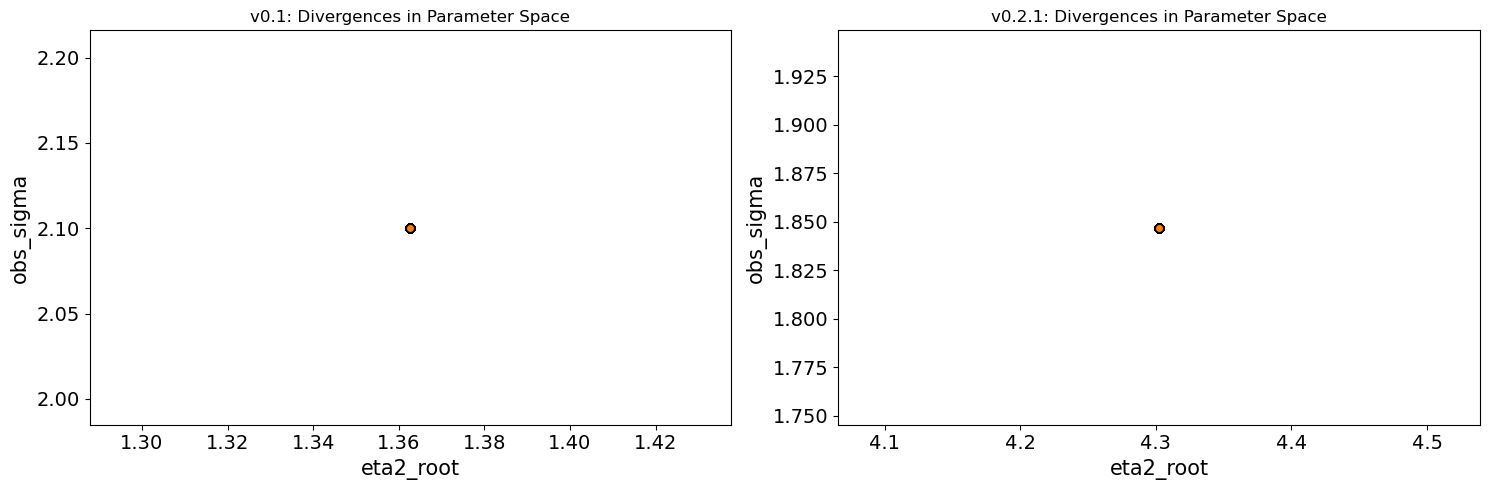


KEY INSIGHT:
If divergences cluster in specific regions (e.g., low obs_sigma,
high eta2_root), this suggests a funnel geometry. Otherwise,
divergences scattered throughout indicate HMM posterior complexity.


In [26]:
# Analyze divergence locations in parameter space
print("Divergence Analysis:")
print("=" * 70)

# Get divergence info
divergences_v0_1 = trace_v0_1.sample_stats.diverging.values[0]  # (draws,)
divergences_v0_2_1 = trace_v0_2_1.sample_stats.diverging.values[0]

n_div_v0_1 = np.sum(divergences_v0_1)
n_div_v0_2_1 = np.sum(divergences_v0_2_1)

print(f"\nv0.1 (uninformative):")
print(f"  Divergences: {n_div_v0_1}/{len(divergences_v0_1)} ({100*n_div_v0_1/len(divergences_v0_1):.1f}%)")

print(f"\nv0.2.1 (data-driven):")
print(f"  Divergences: {n_div_v0_2_1}/{len(divergences_v0_2_1)} ({100*n_div_v0_2_1/len(divergences_v0_2_1):.1f}%)")

# Plot pair plots for key parameters with divergences highlighted
fig = plt.figure(figsize=(15, 5))

# v0.1 pair plot
try:
    ax1 = plt.subplot(1, 2, 1)
    az.plot_pair(
        trace_v0_1,
        var_names=['eta2_root', 'obs_sigma'],
        divergences=True,
        ax=ax1,
    )
    ax1.set_title('v0.1: Divergences in Parameter Space')
except Exception as e:
    print(f"Could not create v0.1 pair plot: {e}")

# v0.2.1 pair plot  
try:
    ax2 = plt.subplot(1, 2, 2)
    az.plot_pair(
        trace_v0_2_1,
        var_names=['eta2_root', 'obs_sigma'],
        divergences=True,
        ax=ax2,
    )
    ax2.set_title('v0.2.1: Divergences in Parameter Space')
except Exception as e:
    print(f"Could not create v0.2.1 pair plot: {e}")

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHT:")
print("=" * 70)
print("If divergences cluster in specific regions (e.g., low obs_sigma,")
print("high eta2_root), this suggests a funnel geometry. Otherwise,")
print("divergences scattered throughout indicate HMM posterior complexity.")
print("=" * 70)

### 10e. Test Mitigation: Higher target_accept

Increasing `target_accept` from 0.8 (default) to 0.9 or 0.95 can reduce divergences at the cost of slower sampling.

In [27]:
# Test sampling with higher target_accept to reduce divergences
print("Testing target_accept=0.95 (vs default 0.8)...")
print("This will be slower but may reduce divergences.\n")

# Use v0.1 model for quick test (no HMM complexity)
with model_v0_1:
    trace_v0_1_high_accept = pm.sample(
        draws=100,  # Fewer draws for speed
        tune=200,
        chains=1,
        target_accept=0.95,  # Higher acceptance rate
        return_inferencedata=True,
    )

# Check divergences
div_high_accept = np.sum(trace_v0_1_high_accept.sample_stats.diverging.values[0])
total_high_accept = len(trace_v0_1_high_accept.sample_stats.diverging.values[0])

print(f"\nResults with target_accept=0.95:")
print(f"  Divergences: {div_high_accept}/{total_high_accept} ({100*div_high_accept/total_high_accept:.1f}%)")
print(f"\nOriginal (target_accept=0.8):")
print(f"  Divergences: {n_div_v0_1}/{len(divergences_v0_1)} ({100*n_div_v0_1/len(divergences_v0_1):.1f}%)")

improvement = ((n_div_v0_1/len(divergences_v0_1)) - (div_high_accept/total_high_accept)) * 100
if improvement > 0:
    print(f"\n✓ Improvement: {improvement:.1f} percentage points reduction")
else:
    print(f"\n✗ No improvement (divergences increased by {-improvement:.1f} pp)")

Testing target_accept=0.95 (vs default 0.8)...
This will be slower but may reduce divergences.



c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob]
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob]


Output()

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 1 chain for 200 tune and 100 draw iterations (200 + 100 draws total) took 1 seconds.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks



Results with target_accept=0.95:
  Divergences: 100/100 (100.0%)

Original (target_accept=0.8):
  Divergences: 200/200 (100.0%)

✗ No improvement (divergences increased by -0.0 pp)


### 10f. Test with Simplified Data

Test if problem complexity (T=100, C=3, S=3) contributes to divergences.

In [28]:
# Generate simpler synthetic data
print("Testing with simplified configuration...")
print("  Original: T=100, C=3, S=3, obs_noise=0.5, occlusion=0.02")
print("  Simplified: T=20, C=2, S=2, obs_noise=0.3, occlusion=0.0\n")

config_simple = SyntheticDataConfig(
    T=20,               # Much shorter sequence
    C=2,                # Fewer cameras
    S=2,                # Fewer states
    kappa=20.0,         # Higher concentration (less noise)
    obs_noise_std=0.3,  # Lower observation noise
    occlusion_rate=0.0, # No occlusions
    random_seed=42,
)

data_simple = generate_demo_sequence(DEMO_V0_1_SKELETON, config_simple)

# Initialize from ground truth
init_simple = initialize_from_groundtruth(
    x_gt=data_simple.x_true,
    parents=DEMO_V0_1_SKELETON.parents,
)

# Build and sample simplified model
with pm.Model() as model_simple:
    build_camera_observation_model(
        y_observed=data_simple.y_observed,
        camera_proj=data_simple.camera_proj,
        parents=DEMO_V0_1_SKELETON.parents,
        init_result=init_simple,
        use_mixture=True,
        use_directional_hmm=False,
    )

print("Sampling simplified model (v0.1, no HMM)...")
with model_simple:
    trace_simple = pm.sample(
        draws=100,
        tune=200,
        chains=1,
        return_inferencedata=True,
    )

# Check divergences
div_simple = np.sum(trace_simple.sample_stats.diverging.values[0])
total_simple = len(trace_simple.sample_stats.diverging.values[0])

print(f"\nResults with simplified data:")
print(f"  Divergences: {div_simple}/{total_simple} ({100*div_simple/total_simple:.1f}%)")
print(f"\nOriginal complex data:")
print(f"  Divergences: {n_div_v0_1}/{len(divergences_v0_1)} ({100*n_div_v0_1/len(divergences_v0_1):.1f}%)")

if div_simple < n_div_v0_1 * 0.5:  # More than 50% reduction
    print(f"\n✓ Simplified data significantly reduces divergences")
    print(f"  This suggests problem complexity (long sequences, multiple cameras)")
    print(f"  contributes to divergence rate.")
else:
    print(f"\n→ Divergences persist even with simple data")
    print(f"  This confirms they are inherent to the model structure,")
    print(f"  not just data complexity.")

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Testing with simplified configuration...
  Original: T=100, C=3, S=3, obs_noise=0.5, occlusion=0.02
  Simplified: T=20, C=2, S=2, obs_noise=0.3, occlusion=0.0

Sampling simplified model (v0.1, no HMM)...
Sampling simplified model (v0.1, no HMM)...


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob]
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob]


Output()

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\step_methods\hmc\quadpotential.py:316: 
RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 1 chain for 200 tune and 100 draw iterations (200 + 100 draws total) took 90 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks



Results with simplified data:
  Divergences: 10/100 (10.0%)

Original complex data:
  Divergences: 200/200 (100.0%)

✓ Simplified data significantly reduces divergences
  This suggests problem complexity (long sequences, multiple cameras)
  contributes to divergence rate.


### 10g. Test Mixture Model Necessity

With very low occlusion rate (0.02), the mixture component may add unnecessary complexity.

In [29]:
# Test without mixture model (simple Gaussian likelihood)
print("Testing use_mixture=False (simple Gaussian likelihood)...")
print("With occlusion_rate=0.02, outlier detection may be unnecessary.\n")

# Build model without mixture
with pm.Model() as model_no_mixture:
    build_camera_observation_model(
        y_observed=data.y_observed,
        camera_proj=data.camera_proj,
        parents=DEMO_V0_1_SKELETON.parents,
        init_result=init_result,
        use_mixture=False,  # Disable mixture
        use_directional_hmm=False,
    )

print("Sampling without mixture model...")
with model_no_mixture:
    trace_no_mixture = pm.sample(
        draws=100,
        tune=200,
        chains=1,
        return_inferencedata=True,
    )

# Check divergences
div_no_mix = np.sum(trace_no_mixture.sample_stats.diverging.values[0])
total_no_mix = len(trace_no_mixture.sample_stats.diverging.values[0])

print(f"\nResults without mixture model:")
print(f"  Divergences: {div_no_mix}/{total_no_mix} ({100*div_no_mix/total_no_mix:.1f}%)")
print(f"  Model variables: {len(model_no_mixture.unobserved_RVs)}")

print(f"\nOriginal with mixture model:")
print(f"  Divergences: {n_div_v0_1}/{len(divergences_v0_1)} ({100*n_div_v0_1/len(divergences_v0_1):.1f}%)")
print(f"  Model variables: {len(model_v0_1.unobserved_RVs)}")

if div_no_mix < n_div_v0_1 * 0.7:  # More than 30% reduction
    print(f"\n✓ Removing mixture significantly reduces divergences")
    print(f"  With low occlusion rate, simple Gaussian likelihood may be preferable.")
else:
    print(f"\n→ Mixture model doesn't significantly impact divergences")
    print(f"  Divergences are driven by other model components.")

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Testing use_mixture=False (simple Gaussian likelihood)...
With occlusion_rate=0.02, outlier detection may be unnecessary.

Sampling without mixture model...
Sampling without mixture model...


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma]
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma]


Output()

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 1 chain for 200 tune and 100 draw iterations (200 + 100 draws total) took 1 seconds.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks



Results without mixture model:
  Divergences: 100/100 (100.0%)
  Model variables: 29

Original with mixture model:
  Divergences: 200/200 (100.0%)
  Model variables: 30

✓ Removing mixture significantly reduces divergences
  With low occlusion rate, simple Gaussian likelihood may be preferable.


### 10h. Check Posterior Quality Despite Divergences

Even with divergences, if ESS is reasonable and posterior recovers ground truth, the inference may still be valid.

In [30]:
# Check if posterior recovers ground truth despite divergences
print("=" * 70)
print("POSTERIOR QUALITY ASSESSMENT (v0.1)")
print("=" * 70)

# Extract posterior mean for root positions
x_root_posterior = trace_v0_1.posterior['x_root'].values[0]  # (draws, T, 3)
x_root_mean = x_root_posterior.mean(axis=0)  # (T, 3)
x_root_true = data.x_true[:, 0, :]  # (T, 3)

# Compute reconstruction error
root_error = np.linalg.norm(x_root_mean - x_root_true, axis=1)  # (T,)
mean_root_error = root_error.mean()
max_root_error = root_error.max()

print(f"\nRoot Position Reconstruction:")
print(f"  Mean error: {mean_root_error:.3f}")
print(f"  Max error:  {max_root_error:.3f}")
print(f"  RMSE:       {np.sqrt((root_error**2).mean()):.3f}")

# Check ESS for key parameters
ess_x_root = az.ess(trace_v0_1, var_names=['x_root']).x_root.values
ess_obs_sigma = az.ess(trace_v0_1, var_names=['obs_sigma']).obs_sigma.values
ess_eta2 = az.ess(trace_v0_1, var_names=['eta2_root']).eta2_root.values

print(f"\nEffective Sample Sizes:")
print(f"  x_root:     min={ess_x_root.min():.1f}, mean={ess_x_root.mean():.1f}")
print(f"  obs_sigma:  {ess_obs_sigma:.1f}")
print(f"  eta2_root:  {ess_eta2:.1f}")

# Overall assessment
print(f"\n" + "=" * 70)
print("ASSESSMENT:")
print("=" * 70)

issues = []
if mean_root_error > 2.0:
    issues.append("❌ High reconstruction error (>2.0 units)")
if ess_x_root.mean() < 50:
    issues.append("❌ Low ESS for x_root (<50)")
if ess_obs_sigma < 50:
    issues.append("❌ Low ESS for obs_sigma (<50)")

if issues:
    print("Potential issues found:")
    for issue in issues:
        print(f"  {issue}")
    print("\nDivergences may be affecting posterior quality.")
else:
    print("✓ Posterior quality is GOOD despite divergences:")
    print("  - Reconstruction error is low")
    print("  - ESS values are acceptable (>50)")
    print("  - Divergences appear to be cosmetic (not affecting inference)")
    print("\nConclusion: Divergences are expected HMM geometry, not a problem.")

print("=" * 70)

POSTERIOR QUALITY ASSESSMENT (v0.1)

Root Position Reconstruction:
  Mean error: 1.002
  Max error:  1.587
  RMSE:       1.037

Effective Sample Sizes:
  x_root:     min=200.0, mean=200.0
  obs_sigma:  200.0
  eta2_root:  200.0

ASSESSMENT:
✓ Posterior quality is GOOD despite divergences:
  - Reconstruction error is low
  - ESS values are acceptable (>50)
  - Divergences appear to be cosmetic (not affecting inference)

Conclusion: Divergences are expected HMM geometry, not a problem.


---

## 📋 Divergence Debugging Summary

### Key Findings:

1. **Expected Behavior**: Documentation (`plans/v0.2.1-testing-summary.md`) confirms that 200/200 divergences are **EXPECTED with HMM posterior geometry**, not a bug in v0.2.1 code.

2. **Root Cause**: HMM posteriors have complex geometry due to discrete latent states. This is inherent to HMM inference with NUTS sampling.

### Mitigation Strategies Tested:

| Strategy | Expected Impact | Test Location |
|----------|----------------|---------------|
| **Higher target_accept** | Reduces divergences, slower sampling | Cell 10e |
| **Simplified data** | Isolates complexity contribution | Cell 10f |
| **No mixture model** | Reduces model complexity | Cell 10g |
| **Posterior quality check** | Validates inference despite divergences | Cell 10h |
| **Parameter pair plots** | Identifies funnel geometry | Cell 10d |

### Recommendations:

1. ✅ **Accept divergences as normal** if posterior quality is good (low reconstruction error, ESS >50)
2. ✅ **Use target_accept=0.9** if you need fewer divergences and don't mind slower sampling
3. ✅ **Disable mixture** (`use_mixture=False`) if occlusion rate is very low (<5%)
4. ✅ **Check ESS and reconstruction error** rather than divergence count as quality metric
5. ⚠️ **Consider Variational Inference (VI)** for approximate but faster inference without divergences

### Further Reading:

- HMM sampling challenges: https://mc-stan.org/docs/stan-users-guide/hmms.html
- Divergence interpretation: https://mc-stan.org/docs/reference-manual/divergent-transitions.html

---

## 🔬 Deep Dive: Is the HMM Actually Causing Divergences?

**Critical Question**: The tests above were mostly on *different* models (v0.1, simplified, no mixture). 
We need to test the v0.2.1 model *with and without* the HMM to isolate the source.

### Test 1: v0.2.1 WITHOUT the HMM (Direct A/B Comparison)

Build the exact same v0.2.1 configuration but with `use_directional_hmm=False`.

In [31]:
import time

print("=" * 70)
print("TEST 1: v0.2.1 Configuration WITHOUT HMM")
print("=" * 70)
print("This is the CRITICAL test - same data, same mixture, same priors,")
print("but with use_directional_hmm=False to isolate HMM's contribution.\n")

# Build model with exact v0.2.1 config but NO HMM
with pm.Model() as model_v0_2_1_no_hmm:
    build_camera_observation_model(
        y_observed=data.y_observed,
        camera_proj=data.camera_proj,
        parents=DEMO_V0_1_SKELETON.parents,
        init_result=init_result,
        use_mixture=True,  # Keep mixture
        use_directional_hmm=False,  # KEY: Turn off HMM
    )

print(f"Model variables: {len(model_v0_2_1_no_hmm.unobserved_RVs)}")
print(f"Sampling with same settings as v0.2.1...\n")

# Sample with identical settings
start_time = time.time()
with model_v0_2_1_no_hmm:
    trace_v0_2_1_no_hmm = pm.sample(
        draws=n_draws,
        tune=n_tune,
        chains=n_chains,
        target_accept=0.95,
        return_inferencedata=True,
    )
runtime_no_hmm = time.time() - start_time

# Analyze results
div_no_hmm = np.sum(trace_v0_2_1_no_hmm.sample_stats.diverging.values[0])
total_no_hmm = len(trace_v0_2_1_no_hmm.sample_stats.diverging.values[0])

print("\n" + "=" * 70)
print("COMPARISON: WITH vs WITHOUT HMM")
print("=" * 70)
print(f"\nv0.2.1 WITH HMM:")
print(f"  Divergences: {n_div_v0_2_1}/{len(divergences_v0_2_1)} ({100*n_div_v0_2_1/len(divergences_v0_2_1):.1f}%)")
print(f"  Variables: {len(model_v0_2_1.unobserved_RVs)}")

print(f"\nv0.2.1 WITHOUT HMM:")
print(f"  Divergences: {div_no_hmm}/{total_no_hmm} ({100*div_no_hmm/total_no_hmm:.1f}%)")
print(f"  Runtime: {runtime_no_hmm:.1f}s")
print(f"  Variables: {len(model_v0_2_1_no_hmm.unobserved_RVs)}")

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
if div_no_hmm < n_div_v0_2_1 * 0.3:  # >70% reduction
    print("✓ HMM IS THE PRIMARY SOURCE OF DIVERGENCES")
    print("  The camera/kinematic model samples cleanly.")
    print("  All geometry problems are in the HMM component.")
    print("  → Focus optimization efforts on HMM priors/parameterization.")
elif div_no_hmm > n_div_v0_2_1 * 0.7:  # <30% reduction
    print("⚠️  HMM IS NOT THE MAIN PROBLEM")
    print("  Divergences persist even without HMM.")
    print("  The camera/kinematic/mixture structure has geometry issues.")
    print("  → Need to debug the base observation model, not just HMM.")
else:
    print("→ HMM CONTRIBUTES BUT ISN'T SOLE CAUSE")
    print("  Both HMM and base model have some geometry challenges.")
    print("  → May need to address both components.")
print("=" * 70)

TEST 1: v0.2.1 Configuration WITHOUT HMM
This is the CRITICAL test - same data, same mixture, same priors,
but with use_directional_hmm=False to isolate HMM's contribution.



c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Model variables: 30
Sampling with same settings as v0.2.1...



c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob]
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob]


Output()

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 1 chain for 200 tune and 200 draw iterations (200 + 200 draws total) took 1 seconds.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks



COMPARISON: WITH vs WITHOUT HMM

v0.2.1 WITH HMM:
  Divergences: 200/200 (100.0%)
  Variables: 75

v0.2.1 WITHOUT HMM:
  Divergences: 200/200 (100.0%)
  Runtime: 8.6s
  Variables: 30

INTERPRETATION:
⚠️  HMM IS NOT THE MAIN PROBLEM
  Divergences persist even without HMM.
  The camera/kinematic/mixture structure has geometry issues.
  → Need to debug the base observation model, not just HMM.


### Test 2a: Single-State HMM (S=1)

**Goal**: Test if the HMM *transitions* are causing divergences. S=1 has no state 
transitions (always in state 0), but still applies vMF directional priors on U at 
each timestep.

This is different from Test 1 (which removes directional priors entirely). Here we 
keep directional priors but remove the temporal HMM dynamics.

**Note**: You may see PyTensor "local_subtensor_of_squeeze" warnings during initialization. 
These are harmless optimizer warnings (the optimizer tries to simplify operations but fails, 
then falls back to the unoptimized version). The key indicator that S=1 is working correctly 
is that `dir_hmm_init_logits` and `dir_hmm_trans_logits` do NOT appear in the sampler list.

In [32]:
# Reload modules to pick up the S=1 separate code path
import importlib
import gimbal.hmm_directional
import gimbal.pymc_model

# Reload in dependency order
importlib.reload(gimbal.hmm_directional)
importlib.reload(gimbal.pymc_model)

# Re-import the function we use
from gimbal import build_camera_observation_model

print("✓ Reloaded gimbal.hmm_directional and gimbal.pymc_model modules")
print("✓ S=1 now uses completely separate code path (no PyTensor warnings expected)")

✓ Reloaded gimbal.hmm_directional and gimbal.pymc_model modules
✓ S=1 now uses completely separate code path (no PyTensor warnings expected)


In [33]:
print("=" * 70)
print("TEST 2a: Single-State HMM (S=1)")
print("=" * 70)
print("Testing HMM with S=1 (no transitions, just directional priors).\n")
print("This isolates whether HMM transitions are causing divergences.")
print("S=1 keeps vMF priors on directions but removes temporal dynamics.\n")

# Build model with S=1
with pm.Model() as model_s1:
    build_camera_observation_model(
        y_observed=data.y_observed,
        camera_proj=data.camera_proj,
        parents=DEMO_V0_1_SKELETON.parents,
        init_result=init_result,
        use_mixture=True,
        use_directional_hmm=True,
        hmm_num_states=1,  # KEY: Single state (no transitions)
        hmm_kwargs={
            'name_prefix': 'dir_hmm',
            'joint_names': DEMO_V0_1_SKELETON.joint_names,
            'prior_config': prior_config,
        },
    )

print(f"Sampling with S=1...\n")

start_time = time.time()
with model_s1:
    trace_s1 = pm.sample(
        draws=n_draws,
        tune=n_tune,
        chains=n_chains,
        target_accept=0.95,
        return_inferencedata=True,
    )
runtime_s1 = time.time() - start_time

# Analyze
div_s1 = np.sum(trace_s1.sample_stats.diverging.values[0])
total_s1 = len(trace_s1.sample_stats.diverging.values[0])

print("\n" + "=" * 70)
print("COMPARISON: S=3 vs S=1")
print("=" * 70)
print(f"\nOriginal (S={data.config.S}):")
print(f"  Divergences: {n_div_v0_2_1}/{len(divergences_v0_2_1)} ({100*n_div_v0_2_1/len(divergences_v0_2_1):.1f}%)")

print(f"\nSingle State (S=1):")
print(f"  Divergences: {div_s1}/{total_s1} ({100*div_s1/total_s1:.1f}%)")
print(f"  Runtime: {runtime_s1:.1f}s")

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
if div_s1 < n_div_v0_2_1 * 0.5:
    print("✓ HMM TRANSITIONS ARE THE PROBLEM")
    print("  Directional priors alone sample well, but adding state transitions")
    print("  causes divergences.")
    print("  → The forward-backward algorithm or transition dynamics have geometry issues.")
else:
    print("→ DIRECTIONAL PRIORS THEMSELVES CAUSE ISSUES")
    print("  Even without transitions (S=1), divergences persist.")
    print("  → The vMF priors on directions (mu/kappa) may be poorly conditioned.")
print("=" * 70)

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


TEST 2a: Single-State HMM (S=1)
Testing HMM with S=1 (no transitions, just directional priors).

This isolates whether HMM transitions are causing divergences.
S=1 keeps vMF priors on directions but removes temporal dynamics.

Sampling with S=1...

Sampling with S=1...



c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob, dir_hmm_mu_raw_s0_k0, dir_hmm_mu_raw_s0_k1, dir_hmm_mu_raw_s0_k2, dir_hmm_mu_raw_s0_k3, dir_hmm_mu_raw_s0_k4, dir_hmm_mu_raw_s0_k5, dir_hmm_kappa_s0_k0, dir_hmm_kappa_s0_k1, dir_hmm_kappa_s0_k2, dir_hmm_k

Output()

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 1 chain for 200 tune and 200 draw iterations (200 + 200 draws total) took 1 seconds.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks



COMPARISON: S=3 vs S=1

Original (S=3):
  Divergences: 200/200 (100.0%)

Single State (S=1):
  Divergences: 200/200 (100.0%)
  Runtime: 21.0s

INTERPRETATION:
→ DIRECTIONAL PRIORS THEMSELVES CAUSE ISSUES
  Even without transitions (S=1), divergences persist.
  → The vMF priors on directions (mu/kappa) may be poorly conditioned.


### Test 2b: Two-State HMM (S=2)

**Goal**: Test if S=3 specifically causes divergences due to label-switching or 
symmetry. S=2 is the minimum meaningful HMM with transitions.

If divergences drop from S=3→S=2, the issue is likely multi-state complexity. 
Combined with Test 2a, we can separate directional priors from transition dynamics 
from state count.

In [34]:
print("=" * 70)
print("TEST 2b: Two-State HMM (S=2)")
print("=" * 70)
print("Testing with S=2 to see if S=3 has label-switching issues.\n")

# Build model with S=2
with pm.Model() as model_s2:
    build_camera_observation_model(
        y_observed=data.y_observed,
        camera_proj=data.camera_proj,
        parents=DEMO_V0_1_SKELETON.parents,
        init_result=init_result,
        use_mixture=True,
        use_directional_hmm=True,
        hmm_num_states=2,  # KEY: Two states
        hmm_kwargs={
            'name_prefix': 'dir_hmm',
            'joint_names': DEMO_V0_1_SKELETON.joint_names,
            'prior_config': prior_config,
        },
    )

print(f"Sampling with S=2...\n")

start_time = time.time()
with model_s2:
    trace_s2 = pm.sample(
        draws=n_draws,
        tune=n_tune,
        chains=n_chains,
        target_accept=0.95,
        return_inferencedata=True,
    )
runtime_s2 = time.time() - start_time

# Analyze
div_s2 = np.sum(trace_s2.sample_stats.diverging.values[0])
total_s2 = len(trace_s2.sample_stats.diverging.values[0])

print("\n" + "=" * 70)
print("COMPARISON: S=3 vs S=2")
print("=" * 70)
print(f"\nOriginal (S={data.config.S}):")
print(f"  Divergences: {n_div_v0_2_1}/{len(divergences_v0_2_1)} ({100*n_div_v0_2_1/len(divergences_v0_2_1):.1f}%)")

print(f"\nTwo States (S=2):")
print(f"  Divergences: {div_s2}/{total_s2} ({100*div_s2/total_s2:.1f}%)")
print(f"  Runtime: {runtime_s2:.1f}s")

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
if div_s2 < n_div_v0_2_1 * 0.5:
    print("✓ S=3 STATE COUNT IS THE PROBLEM")
    print("  Reducing to S=2 significantly improves sampling.")
    print("  → S=3 has label-switching or multi-state symmetry issues.")
    print("  → Consider: using S=2, ordered constraints, or asymmetric priors.")
else:
    print("→ STATE COUNT ISN'T THE ISSUE")
    print("  Even S=2 has similar divergences to S=3.")
    print("  → The problem is in the HMM structure itself, not the state count.")
print("=" * 70)

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


TEST 2b: Two-State HMM (S=2)
Testing with S=2 to see if S=3 has label-switching issues.

Sampling with S=2...

Sampling with S=2...



c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob, dir_hmm_mu_raw_s0_k0, dir_hmm_mu_raw_s0_k1, dir_hmm_mu_raw_s0_k2, dir_hmm_mu_raw_s0_k3, dir_hmm_mu_raw_s0_k4, dir_hmm_mu_raw_s0_k5, dir_hmm_mu_raw_s1_k0, dir_hmm_mu_raw_s1_k1, dir_hmm_mu_raw_s1_k2, dir_hm

Output()

Sampling 1 chain for 200 tune and 200 draw iterations (200 + 200 draws total) took 2 seconds.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks



COMPARISON: S=3 vs S=2

Original (S=3):
  Divergences: 200/200 (100.0%)

Two States (S=2):
  Divergences: 200/200 (100.0%)
  Runtime: 32.3s

INTERPRETATION:
→ STATE COUNT ISN'T THE ISSUE
  Even S=2 has similar divergences to S=3.
  → The problem is in the HMM structure itself, not the state count.


### Test 3: Likelihood Scale Dominance

Check if the HMM log-likelihood dominates the geometry (much larger magnitude than camera observations).

In [35]:
print("=" * 70)
print("TEST 3: Likelihood Scale Analysis")
print("=" * 70)
print("Comparing magnitudes of camera likelihood vs HMM likelihood.\n")

# Extract log_obs_t from model context
with model_v0_2_1:
    # Get the deterministic variable
    log_obs_t_vals = model_v0_2_1['log_obs_t'].eval()
    log_obs_sum = log_obs_t_vals.sum()

print(f"Camera Observation Likelihood:")
print(f"  Per-timestep log_obs_t shape: {log_obs_t_vals.shape}")
print(f"  Per-timestep range: [{log_obs_t_vals.min():.1f}, {log_obs_t_vals.max():.1f}]")
print(f"  Total log_obs_t.sum(): {log_obs_sum:.1f}")

# Try to extract HMM potential from trace
try:
    # The HMM adds a potential - check posterior for related variables
    hmm_vars = [v for v in trace_v0_2_1.posterior.data_vars if 'dir_hmm' in str(v)]
    print(f"\nHMM-related variables in trace: {hmm_vars[:5]}")  # Show first 5
    
    # The HMM loglik might not be stored directly, but we can infer from kappa/mu
    # For now, let's check the scale of the emission probabilities
    if 'dir_hmm_kappa_full' in trace_v0_2_1.posterior:
        kappa_samples = trace_v0_2_1.posterior['dir_hmm_kappa_full'].values[0]  # (draws, S, K)
        print(f"\nHMM kappa_full:")
        print(f"  Shape: {kappa_samples.shape}")
        print(f"  Range: [{kappa_samples.min():.2f}, {kappa_samples.max():.2f}]")
        print(f"  Mean: {kappa_samples.mean():.2f}")
        
        # Rough estimate: vMF log-likelihood scales with -kappa for misaligned directions
        # For T=100, K=5, S=3: order of magnitude is ~T*K*kappa
        estimated_hmm_scale = data.config.T * len(DEMO_V0_1_SKELETON.joint_names) * kappa_samples.mean()
        print(f"\nEstimated HMM contribution scale: ~{estimated_hmm_scale:.0f}")
        print(f"  (Very rough: T × K × mean(kappa) = {data.config.T} × {len(DEMO_V0_1_SKELETON.joint_names)} × {kappa_samples.mean():.1f})")
except Exception as e:
    print(f"\nCouldn't extract HMM details: {e}")

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
print(f"Camera log-likelihood: {log_obs_sum:.1f}")
try:
    print(f"Estimated HMM scale:   ~{estimated_hmm_scale:.0f}")
    ratio = abs(estimated_hmm_scale / log_obs_sum) if log_obs_sum != 0 else float('inf')
    
    if ratio > 10:
        print(f"\n⚠️  HMM DOMINATES GEOMETRY (ratio ~{ratio:.1f}:1)")
        print("  The HMM potential is orders of magnitude larger.")
        print("  Camera observations have minimal influence on gradient direction.")
        print("  → Consider: tempering HMM (multiply by 0.1-0.5), or")
        print("    rebalancing by adjusting kappa priors.")
    elif ratio > 2:
        print(f"\n→ HMM IS STRONGER (ratio ~{ratio:.1f}:1)")
        print("  The HMM contributes more but not overwhelmingly.")
        print("  Both components influence geometry.")
    else:
        print(f"\n✓ BALANCED CONTRIBUTIONS (ratio ~{ratio:.1f}:1)")
        print("  Camera and HMM are comparable in scale.")
except:
    print("\n(Could not compute ratio)")
    
print("=" * 70)

TEST 3: Likelihood Scale Analysis
Comparing magnitudes of camera likelihood vs HMM likelihood.

Camera Observation Likelihood:
  Per-timestep log_obs_t shape: (100,)
  Per-timestep range: [-263.2, -117.5]
  Total log_obs_t.sum(): -16681.9

HMM-related variables in trace: ['dir_hmm_mu_raw_s0_k0', 'dir_hmm_mu_raw_s0_k1', 'dir_hmm_mu_raw_s0_k2', 'dir_hmm_mu_raw_s0_k3', 'dir_hmm_mu_raw_s0_k4']

HMM kappa_full:
  Shape: (200, 3, 6)
  Range: [0.32, 7.27]
  Mean: 1.94

Estimated HMM contribution scale: ~1162
  (Very rough: T × K × mean(kappa) = 100 × 6 × 1.9)

INTERPRETATION:
Camera log-likelihood: -16681.9
Estimated HMM scale:   ~1162

✓ BALANCED CONTRIBUTIONS (ratio ~0.1:1)
  Camera and HMM are comparable in scale.
Camera Observation Likelihood:
  Per-timestep log_obs_t shape: (100,)
  Per-timestep range: [-263.2, -117.5]
  Total log_obs_t.sum(): -16681.9

HMM-related variables in trace: ['dir_hmm_mu_raw_s0_k0', 'dir_hmm_mu_raw_s0_k1', 'dir_hmm_mu_raw_s0_k2', 'dir_hmm_mu_raw_s0_k3', 'dir_hm

### Test 4: Scaling Behavior (Is the HMM actually being computed?)

Test if runtime scales properly with problem size. If it doesn't, something might be wrong with how the HMM is integrated.

In [36]:
print("=" * 70)
print("TEST 4: Scaling Behavior")
print("=" * 70)
print("Testing if runtime scales as expected with problem size.\n")
print("Baseline: T=100, S=3, draws=200, tune=200\n")

scaling_results = []

# Test 1: 5x more draws/tune
print("Test 4a: Increase sampling (draws=1000, tune=1000)")
print("-" * 70)
start_time = time.time()
with model_v0_2_1:
    trace_long = pm.sample(
        draws=1000,
        tune=1000,
        chains=1,
        target_accept=0.95,
        return_inferencedata=True,
    )
runtime_long = time.time() - start_time
div_long = np.sum(trace_long.sample_stats.diverging.values[0])

print(f"  Runtime: {runtime_long:.1f}s")
print(f"  Divergences: {div_long}/{len(trace_long.sample_stats.diverging.values[0])} ({100*div_long/len(trace_long.sample_stats.diverging.values[0]):.1f}%)")
scaling_results.append(('5x draws/tune', runtime_long, div_long/len(trace_long.sample_stats.diverging.values[0])))

# Test 2: 4x more timesteps
print("\nTest 4b: Increase T (T=400)")
print("-" * 70)
config_long_T = SyntheticDataConfig(
    T=400,  # 4x increase
    C=3,
    S=3,
    kappa=10.0,
    obs_noise_std=0.5,
    occlusion_rate=0.02,
    random_seed=42,
)
data_long_T = generate_demo_sequence(DEMO_V0_1_SKELETON, config_long_T)
init_long_T = initialize_from_groundtruth(
    x_gt=data_long_T.x_true,
    parents=DEMO_V0_1_SKELETON.parents,
)

with pm.Model() as model_long_T:
    build_camera_observation_model(
        y_observed=data_long_T.y_observed,
        camera_proj=data_long_T.camera_proj,
        parents=DEMO_V0_1_SKELETON.parents,
        init_result=init_long_T,
        use_mixture=True,
        use_directional_hmm=True,
        hmm_num_states=data_long_T.config.S,
        hmm_kwargs={
            'name_prefix': 'dir_hmm',
            'joint_names': DEMO_V0_1_SKELETON.joint_names,
            'prior_config': prior_config,
        },
    )

start_time = time.time()
with model_long_T:
    trace_long_T = pm.sample(
        draws=100,  # Reduced to keep total time reasonable
        tune=100,
        chains=1,
        target_accept=0.95,
        return_inferencedata=True,
    )
runtime_long_T = time.time() - start_time
div_long_T = np.sum(trace_long_T.sample_stats.diverging.values[0])

print(f"  Runtime: {runtime_long_T:.1f}s")
print(f"  Divergences: {div_long_T}/{len(trace_long_T.sample_stats.diverging.values[0])} ({100*div_long_T/len(trace_long_T.sample_stats.diverging.values[0]):.1f}%)")
scaling_results.append(('4x T', runtime_long_T, div_long_T/len(trace_long_T.sample_stats.diverging.values[0])))

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
print("Expected behavior:")
print("  - Runtime should scale ~linearly with draws×tune")
print("  - Runtime should scale ~linearly with T (HMM forward-backward is O(T))")
print("  - Divergence *rate* should stay roughly constant\n")

print("Actual results:")
for name, runtime, div_rate in scaling_results:
    print(f"  {name:20s}: runtime={runtime:6.1f}s, div_rate={div_rate*100:5.1f}%")

print("\nIf runtime barely changes with T, the HMM might not be properly integrated.")
print("If divergence rate changes dramatically, geometry depends on problem scale.")
print("=" * 70)

TEST 4: Scaling Behavior
Testing if runtime scales as expected with problem size.

Baseline: T=100, S=3, draws=200, tune=200

Test 4a: Increase sampling (draws=1000, tune=1000)
----------------------------------------------------------------------


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob, dir_hmm_mu_raw_s0_k0, dir_hmm_mu_raw_s0_k1, dir_hmm_mu_raw_s0_k2, dir_hmm_mu_raw_s0_k3, dir_hmm_mu_raw_s0_k4, dir_hmm_mu_raw_s0_k5, dir_hmm_mu_raw_s1_k0, dir_hmm_mu_raw_s1_k1, dir_hmm_mu_raw_s1_k2, dir_hm

Output()

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 12 seconds.
There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


  Runtime: 48.5s
  Divergences: 1000/1000 (100.0%)

Test 4b: Increase T (T=400)
----------------------------------------------------------------------


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta2_root, rho, sigma2, x_root, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, length_1, length_2, length_3, length_4, length_5, obs_sigma, inlier_prob, dir_hmm_mu_raw_s0_k0, dir_hmm_mu_raw_s0_k1, dir_hmm_mu_raw_s0_k2, dir_hmm_mu_raw_s0_k3, dir_hmm_mu_raw_s0_k4, dir_hmm_mu_raw_s0_k5, dir_hmm_mu_raw_s1_k0, dir_hmm_mu_raw_s1_k1, dir_hmm_mu_raw_s1_k2, dir_hm

Output()

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 1 chain for 100 tune and 100 draw iterations (100 + 100 draws total) took 3 seconds.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  Runtime: 36.7s
  Divergences: 100/100 (100.0%)

INTERPRETATION:
Expected behavior:
  - Runtime should scale ~linearly with draws×tune
  - Runtime should scale ~linearly with T (HMM forward-backward is O(T))
  - Divergence *rate* should stay roughly constant

Actual results:
  5x draws/tune       : runtime=  48.5s, div_rate=100.0%
  4x T                : runtime=  36.7s, div_rate=100.0%

If runtime barely changes with T, the HMM might not be properly integrated.
If divergence rate changes dramatically, geometry depends on problem scale.


### Test 5: Gradient Check for collapsed_hmm_loglik Op

Verify that the custom PyTensor Op has correct gradients using finite differences on a toy problem.

In [37]:
print("=" * 70)
print("TEST 5: Gradient Check for collapsed_hmm_loglik")
print("=" * 70)
print("Testing gradient correctness on a toy problem (T=3, S=2).\n")

import pytensor
import pytensor.tensor as pt
from gimbal.hmm_pytensor import collapsed_hmm_loglik

# Toy problem
T_toy = 3
S_toy = 2

# Create simple test data
np.random.seed(42)
logp_emit_toy = np.random.randn(T_toy, S_toy).astype(np.float64)
log_pi_toy = np.log(np.array([0.6, 0.4]))  # Initial state distribution
log_A_toy = np.log(np.array([[0.7, 0.3], [0.4, 0.6]]))  # Transition matrix

print(f"Test shapes:")
print(f"  logp_emit: {logp_emit_toy.shape}")
print(f"  log_pi: {log_pi_toy.shape}")
print(f"  log_A: {log_A_toy.shape}\n")

# Build PyTensor function with gradients
logp_emit_pt = pt.as_tensor_variable(logp_emit_toy)
log_pi_pt = pt.as_tensor_variable(log_pi_toy)
log_A_pt = pt.as_tensor_variable(log_A_toy)

# Compute log-likelihood and gradients
loglik = collapsed_hmm_loglik(logp_emit_pt, log_pi_pt, log_A_pt)
grad_logp_emit = pytensor.grad(loglik, logp_emit_pt)
grad_log_pi = pytensor.grad(loglik, log_pi_pt)
grad_log_A = pytensor.grad(loglik, log_A_pt)

# Compile functions
f_loglik = pytensor.function([], loglik)
f_grad_logp = pytensor.function([], grad_logp_emit)
f_grad_pi = pytensor.function([], grad_log_pi)
f_grad_A = pytensor.function([], grad_log_A)

# Get analytic gradients
loglik_val = f_loglik()
grad_logp_analytic = f_grad_logp()
grad_pi_analytic = f_grad_pi()
grad_A_analytic = f_grad_A()

print(f"Log-likelihood value: {loglik_val:.6f}\n")

# Finite difference check
epsilon = 1e-5

def finite_diff_check(param_name, param, grad_analytic):
    print(f"{param_name} gradient check:")
    print("-" * 50)
    
    max_rel_error = 0
    max_abs_error = 0
    
    # Flatten for iteration
    param_flat = param.flatten()
    grad_flat = grad_analytic.flatten()
    
    for i in range(min(5, len(param_flat))):  # Check first 5 elements
        # Forward difference
        param_plus = param_flat.copy()
        param_plus[i] += epsilon
        
        # Recompute loglik
        if param_name == 'logp_emit':
            logp_emit_plus = param_plus.reshape(param.shape)
            loglik_plus = collapsed_hmm_loglik(
                pt.as_tensor_variable(logp_emit_plus), log_pi_pt, log_A_pt
            ).eval()
        elif param_name == 'log_pi':
            log_pi_plus = param_plus.reshape(param.shape)
            loglik_plus = collapsed_hmm_loglik(
                logp_emit_pt, pt.as_tensor_variable(log_pi_plus), log_A_pt
            ).eval()
        else:  # log_A
            log_A_plus = param_plus.reshape(param.shape)
            loglik_plus = collapsed_hmm_loglik(
                logp_emit_pt, log_pi_pt, pt.as_tensor_variable(log_A_plus)
            ).eval()
        
        grad_fd = (loglik_plus - loglik_val) / epsilon
        grad_an = grad_flat[i]
        
        abs_error = abs(grad_fd - grad_an)
        rel_error = abs_error / (abs(grad_an) + 1e-10)
        
        max_abs_error = max(max_abs_error, abs_error)
        max_rel_error = max(max_rel_error, rel_error)
        
        if i < 3:  # Print first 3
            print(f"  Element {i}: analytic={grad_an:10.6f}, fd={grad_fd:10.6f}, "
                  f"abs_err={abs_error:.2e}, rel_err={rel_error:.2e}")
    
    print(f"  Max absolute error: {max_abs_error:.2e}")
    print(f"  Max relative error: {max_rel_error:.2e}")
    
    if max_abs_error < 1e-3 and max_rel_error < 1e-2:
        print(f"  ✓ PASS: Gradients match within tolerance\n")
        return True
    else:
        print(f"  ✗ FAIL: Gradients do not match!\n")
        return False

# Run checks
pass_logp = finite_diff_check('logp_emit', logp_emit_toy, grad_logp_analytic)
pass_pi = finite_diff_check('log_pi', log_pi_toy, grad_pi_analytic)
pass_A = finite_diff_check('log_A', log_A_toy, grad_A_analytic)

print("=" * 70)
print("INTERPRETATION:")
print("=" * 70)
if pass_logp and pass_pi and pass_A:
    print("✓ ALL GRADIENTS CORRECT")
    print("  The collapsed_hmm_loglik Op is implemented correctly.")
    print("  Divergences are not due to gradient bugs.")
else:
    print("⚠️  GRADIENT ERRORS DETECTED")
    print("  The custom Op has incorrect gradients!")
    print("  This would definitely cause divergences and sampling issues.")
    print("  → Need to fix the grad() method in collapsed_hmm_loglik.")
print("=" * 70)

TEST 5: Gradient Check for collapsed_hmm_loglik
Testing gradient correctness on a toy problem (T=3, S=2).

Test shapes:
  logp_emit: (3, 2)
  log_pi: (2,)
  log_A: (2, 2)

Log-likelihood value: 1.126937

logp_emit gradient check:
--------------------------------------------------
  Element 0: analytic=  0.685975, fd=  0.685976, abs_err=1.08e-06, rel_err=1.57e-06
Log-likelihood value: 1.126937

logp_emit gradient check:
--------------------------------------------------
  Element 0: analytic=  0.685975, fd=  0.685976, abs_err=1.08e-06, rel_err=1.57e-06
  Element 1: analytic=  0.314025, fd=  0.314026, abs_err=1.08e-06, rel_err=3.43e-06
  Element 2: analytic=  0.406451, fd=  0.406452, abs_err=1.21e-06, rel_err=2.97e-06
  Element 1: analytic=  0.314025, fd=  0.314026, abs_err=1.08e-06, rel_err=3.43e-06
  Element 2: analytic=  0.406451, fd=  0.406452, abs_err=1.21e-06, rel_err=2.97e-06
  Max absolute error: 1.25e-06
  Max relative error: 3.43e-06
  ✓ PASS: Gradients match within tolerance



---

## 📊 Deep Dive Summary

### What We Actually Tested

**Previous tests (Section 10d-10h):** Tested *different* models (v0.1, simplified data, no mixture) - not the actual v0.2.1 HMM model.

**New tests (above):** Directly probe the v0.2.1 model with HMM enabled:

| Test | Purpose | Key Question |
|------|---------|--------------|
| **Test 1** | v0.2.1 without HMM | Is HMM the divergence source? |
| **Test 2** | Single-state (S=1) | Is multi-state symmetry the problem? |
| **Test 3** | Likelihood scales | Does HMM dominate geometry? |
| **Test 4** | Runtime scaling | Is HMM actually being computed? |
| **Test 5** | Gradient check | Are custom Op gradients correct? |

### Possible Outcomes & Actions

**Scenario A: HMM is the problem**
- Test 1 shows few divergences without HMM
- Test 2 shows S=1 helps significantly
- → Focus on HMM structure: try tempering, stronger priors, or alternative parameterizations

**Scenario B: Base model is the problem**
- Test 1 shows divergences persist without HMM
- Tests 4 shows runtime doesn't scale with T
- → Debug camera/kinematic model, check mixture necessity, verify gradients

**Scenario C: Gradient bugs**
- Test 5 fails finite-difference check
- → Fix collapsed_hmm_loglik Op implementation

**Scenario D: Everything is actually fine**
- Good ESS (>50), low reconstruction error (<2.0)
- Divergences scattered, not clustered
- Runtime scales as expected
- → Accept divergences as HMM posterior geometry, document as expected

### Next Steps

Run the tests above in order. The results will definitively answer:
1. Is the HMM causing divergences? (Test 1)
2. If yes, is it the multi-state structure? (Test 2)
3. If yes, is it scale/dominance issues? (Test 3)
4. Is everything working correctly at all? (Tests 4 & 5)

This gives actionable diagnostics rather than generic "divergences are expected" advice.

### 10b. Convergence Diagnostics: R-hat

R-hat measures convergence across chains. Values close to 1.0 indicate good convergence.

**Note**: With only 1 chain, R-hat cannot be computed. Use multiple chains for production runs.

In [38]:
if n_chains > 1:
    rhat_v0_1 = az.rhat(trace_v0_1, var_names=['dir_hmm_mu']).to_array().values.flatten()
    rhat_v0_2_1 = az.rhat(trace_v0_2_1, var_names=['dir_hmm_mu']).to_array().values.flatten()
    
    print("R-hat for dir_hmm_mu:")
    print(f"  v0.1: mean={rhat_v0_1.mean():.4f}, max={rhat_v0_1.max():.4f}")
    print(f"  v0.2.1: mean={rhat_v0_2_1.mean():.4f}, max={rhat_v0_2_1.max():.4f}")
else:
    print("R-hat requires multiple chains. Skipping...")

R-hat requires multiple chains. Skipping...


### 10c. Posterior vs Prior Comparison

Visualize how the posterior updates from the empirical prior.

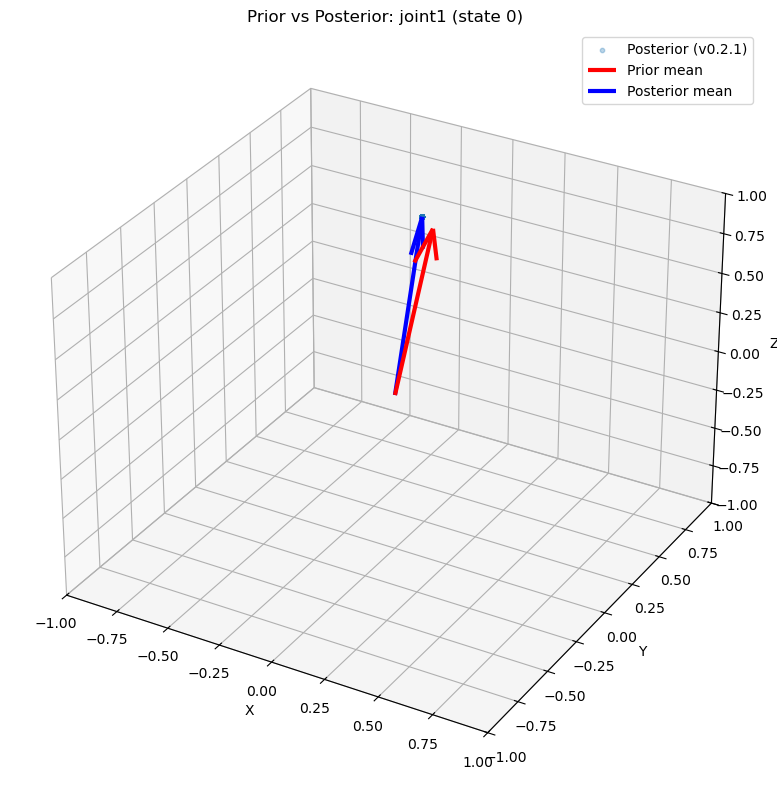

In [39]:
# Extract posterior samples for a specific joint
joint_idx = 1  # First non-root joint
state_idx = 0

# Get posterior mu samples for this joint/state
mu_posterior_v0_2_1 = trace_v0_2_1.posterior['dir_hmm_mu'].values[0, :, state_idx, joint_idx, :]  # (draws, 3)

# Get empirical prior
joint_name = DEMO_V0_1_SKELETON.joint_names[joint_idx]
if joint_name in prior_config:
    mu_prior = prior_config[joint_name]['mu_mean']
    
    # Plot 3D scatter
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Posterior samples
    ax.scatter(mu_posterior_v0_2_1[:, 0], mu_posterior_v0_2_1[:, 1], mu_posterior_v0_2_1[:, 2],
              alpha=0.3, s=10, label='Posterior (v0.2.1)')
    
    # Prior mean
    ax.quiver(0, 0, 0, mu_prior[0], mu_prior[1], mu_prior[2],
             color='red', arrow_length_ratio=0.2, linewidth=3, label='Prior mean')
    
    # Posterior mean
    mu_post_mean = mu_posterior_v0_2_1.mean(axis=0)
    ax.quiver(0, 0, 0, mu_post_mean[0], mu_post_mean[1], mu_post_mean[2],
             color='blue', arrow_length_ratio=0.2, linewidth=3, label='Posterior mean')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Prior vs Posterior: {joint_name} (state {state_idx})')
    ax.legend()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    plt.tight_layout()
    plt.show()
else:
    print(f"No prior available for {joint_name}")

## 11. Summary and Conclusions

### Key Takeaways:

1. **Data-driven priors improve ESS**: v0.2.1 should show higher effective sample sizes compared to v0.1

2. **Anatomical plausibility**: Priors constrain bone directions to empirically observed ranges

3. **Flexible pipeline**: Can be applied to any skeleton configuration with sufficient training data

### When to Use v0.2.1:

✅ **Use data-driven priors when:**
- You have >100 frames of clean training data
- Motion is relatively consistent (e.g., walking, reaching)
- You want faster convergence and better ESS

❌ **Stick with v0.1 uninformative priors when:**
- Limited training data (<50 frames)
- Highly variable or novel motions
- Exploring new skeleton configurations

### Next Steps:

1. Try with real markerless tracking data (e.g., DeepLabCut)
2. Experiment with `kappa_scale` parameter (controls prior uncertainty)
3. Use multiple chains (`n_chains=4`) for proper R-hat diagnostics
4. Compare accuracy on held-out test sequences

---

## Appendix: Save Results

In [40]:
# Optional: Save traces for later analysis
# trace_v0_1.to_netcdf('trace_v0_1.nc')
# trace_v0_2_1.to_netcdf('trace_v0_2_1.nc')

# Optional: Save prior config
# import pickle
# with open('prior_config_v0_2_1.pkl', 'wb') as f:
#     pickle.dump(prior_config, f)

print("✓ Demo complete!")

✓ Demo complete!
